In [67]:
import pickle
import numpy as np
import pandas as pd
from data_process import Get_Offense
from class_offfense import Offense
import distance_utils
import time
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns

import importlib
importlib.reload(distance_utils)
from distance_utils import *


# preprocessing

In [2]:
def get_data():
    with open('data/final_data.pkl', 'rb') as file:
        loaded_data = pickle.load(file)
    list_offense =[]
    for o in loaded_data:
        list_offense.append(Offense(o))

    return(list_offense)

In [3]:
list_offense = get_data()
len(list_offense)

67820

In [4]:
list_offense = [offense for offense in list_offense if len(offense.list_coords) > 1]
len(list_offense)

63872

In [5]:
max_time = -1
for o in list_offense:
    o.list_coords = o.list_coords[:8]
    o.list_action_type = o.list_action_type[:8]
    o.list_time = o.list_time[:8]
    m_time = o.list_time[-1]
    if m_time > max_time:
        max_time = m_time

max_time

248

In [ ]:
for i, offense in enumerate(list_offense):
    offense.index_in_current_list = i

print(list_offense[5].index_in_current_list)

# EDA

In [35]:
data = []

# Iterate through the list of Offense objects and extract the desired statistics
for offense in list_offense:
    if offense.list_coords[-1][0] < 60:
        d= offense.list_coords[-1][0]
    else:
        d = 120 - offense.list_coords[-1][0]
    c =0 
    p = 0
    dribble = 0
    for a in offense.list_action_type:
        if a == "Carry":
            c +=1
        elif a == "Pass":
            p += 1
        elif a == "Dribble":
            dribble += 1
    if offense.list_time[-1] < 0:
        s_t = 0
    else:
        s_t = offense.list_time[-1]
    data.append({
        'play_pattern': offense.play_pattern,
        'end_location': offense.end_location,
        'outcome': offense.outcome,
        'len_offense': len(offense.list_coords),
        'shot_distance': d,
        "carry" : c ,
        "pass" : p,
        "dribble" : dribble,
        'shot_time': s_t,
    })

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

In [36]:
df.head()

,play_pattern,end_location,outcome,len_offense,shot_distance,carry,pass,dribble,shot_time
0,Regular Play,"[120.0, 35.2, 1.0]",Off T,8,19.4,4,4,0,14
1,From Throw In,"[120.0, 39.3, 0.5]",Goal,4,9.1,1,2,0,6
2,From Throw In,"[118.1, 30.2]",Blocked,8,14.6,4,4,0,5
3,From Counter,"[120.0, 39.0, 0.2]",Goal,8,18.2,4,2,1,22
4,Regular Play,"[118.8, 36.0, 0.2]",Saved,8,41.6,3,5,0,14


In [37]:
df.to_csv('data/offense_eda.csv', index=False)


In [38]:
df.describe()

,len_offense,shot_distance,carry,pass,dribble,shot_time
count,67820.000000,67820.000000,67820.000000,67820.000000,67820.000000,67820.000000
mean,5.848422,25.318424,2.266912,2.851887,0.124491,9.286553
std,2.566860,15.619958,1.514360,1.661044,0.364206,7.243417
min,1.000000,-0.200000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,12.100000,1.000000,1.000000,0.000000,4.000000
50%,8.000000,22.500000,3.000000,3.000000,0.000000,9.000000
75%,8.000000,35.800000,4.000000,4.000000,0.000000,13.000000
max,8.000000,60.000000,5.000000,8.000000,4.000000,248.000000


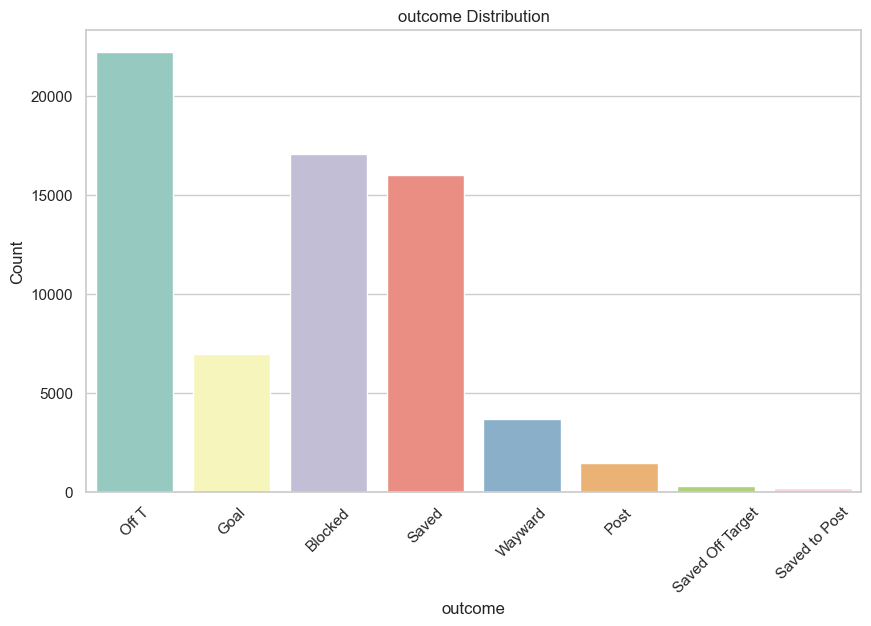

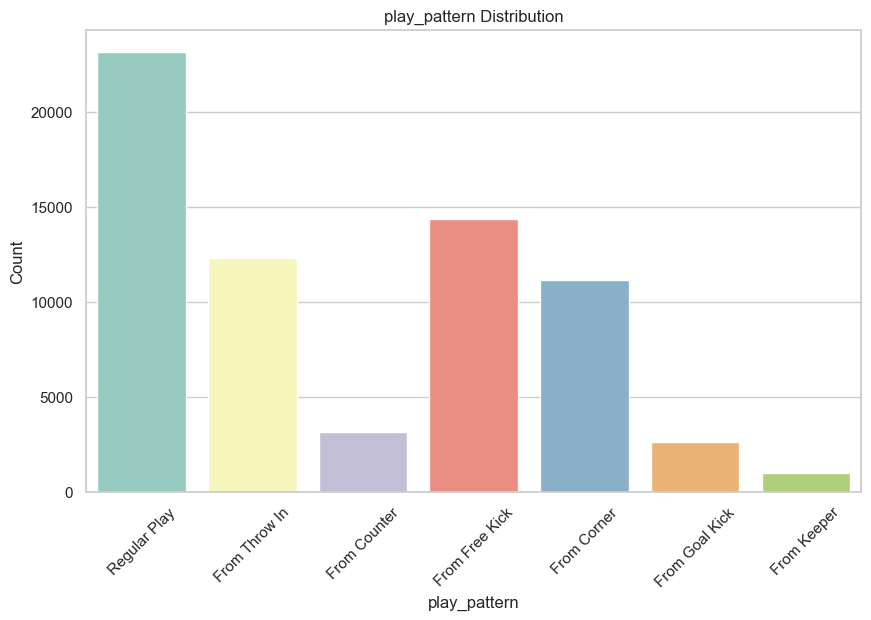

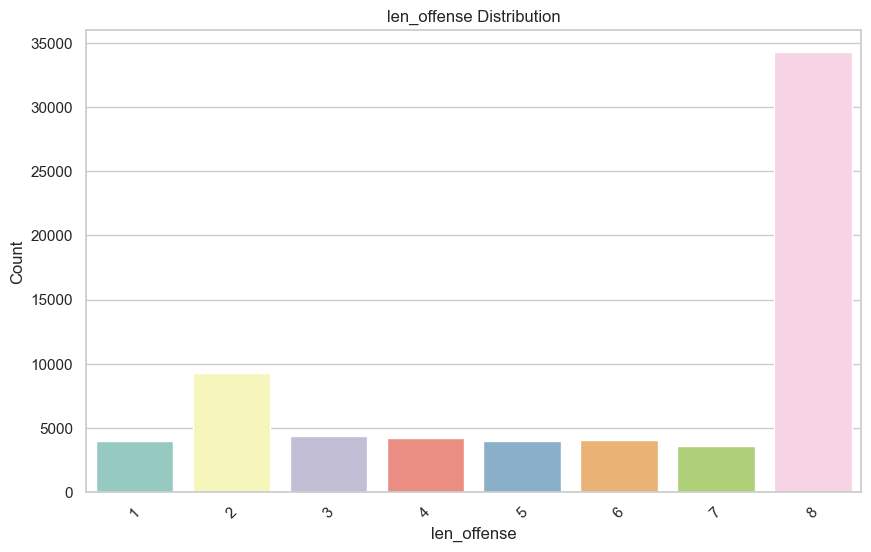

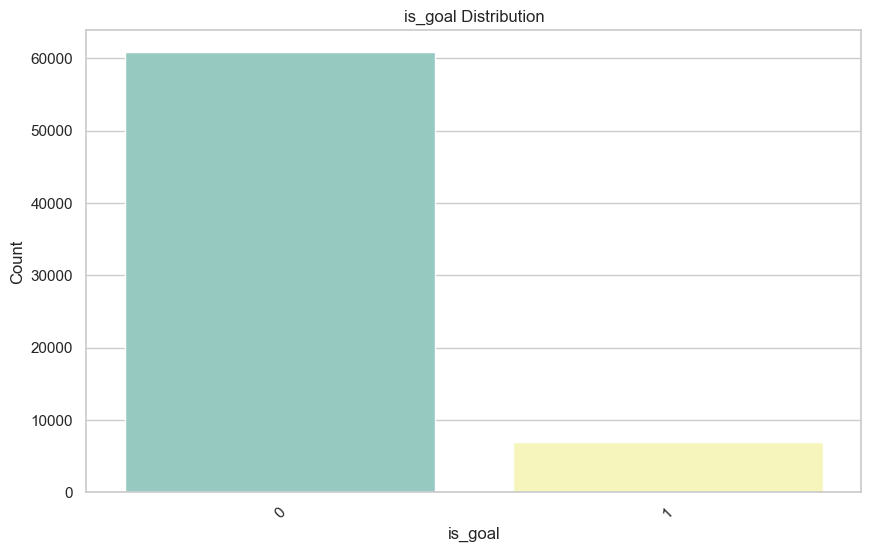

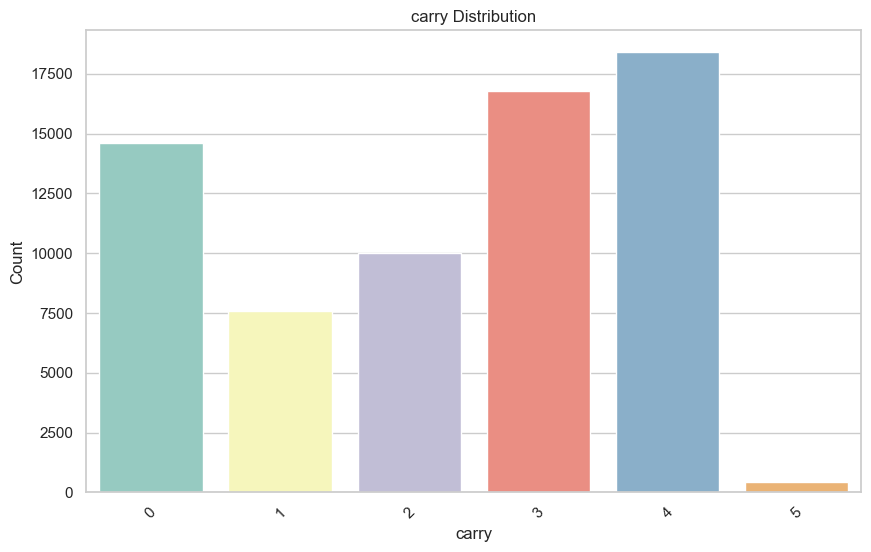

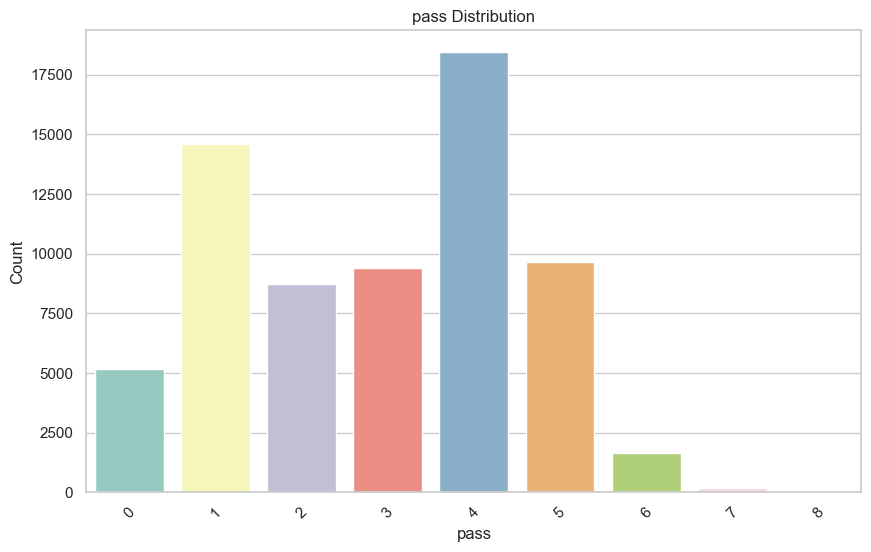

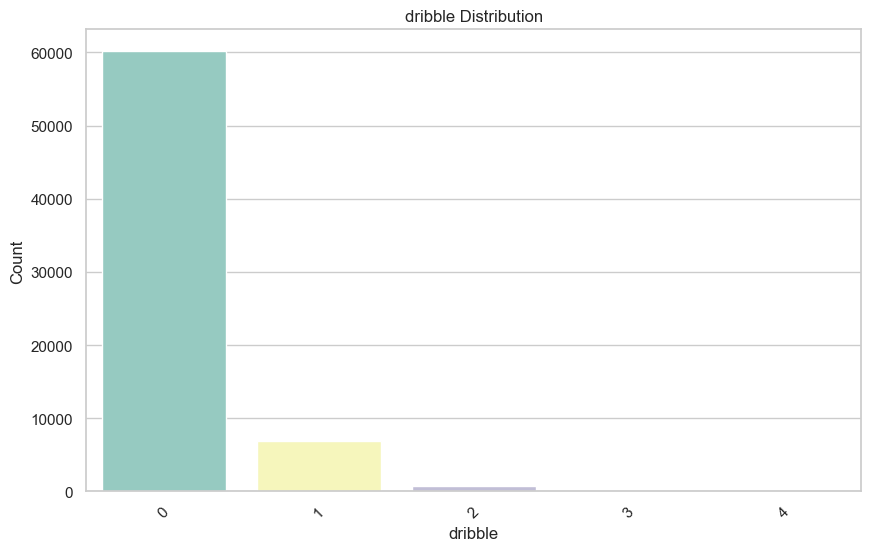

In [68]:
df['is_goal'] = df['outcome'].apply(lambda x: 1 if x == 'Goal' else 0)
columns= ["outcome" , "play_pattern" , "len_offense" , "is_goal" , "carry",	"pass",	"dribble"]
for c in columns:
    # Set the style of seaborn
    sns.set(style="whitegrid")

    # Create a bar plot for outcome distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=c, data=df, palette="Set3")
    plt.xlabel(c)
    plt.ylabel('Count')
    plt.title(f'{c} Distribution')
    plt.xticks(rotation=45)
    plt.show()


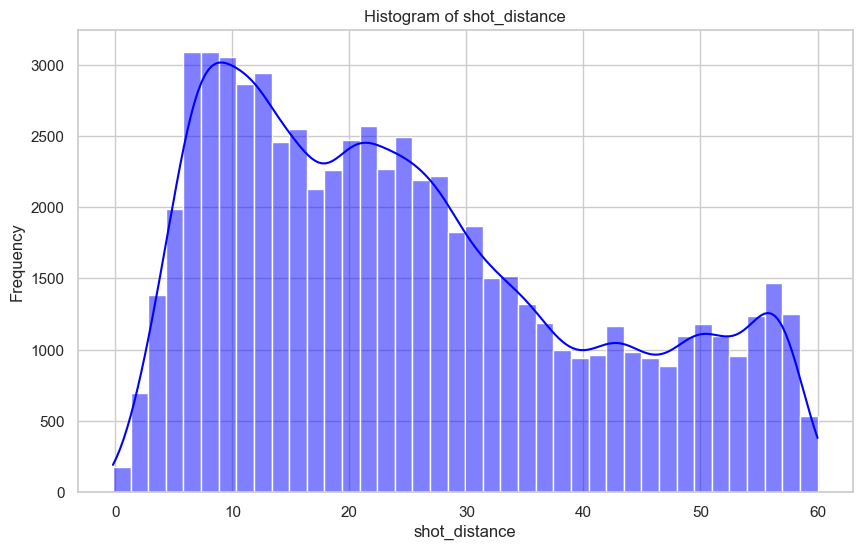

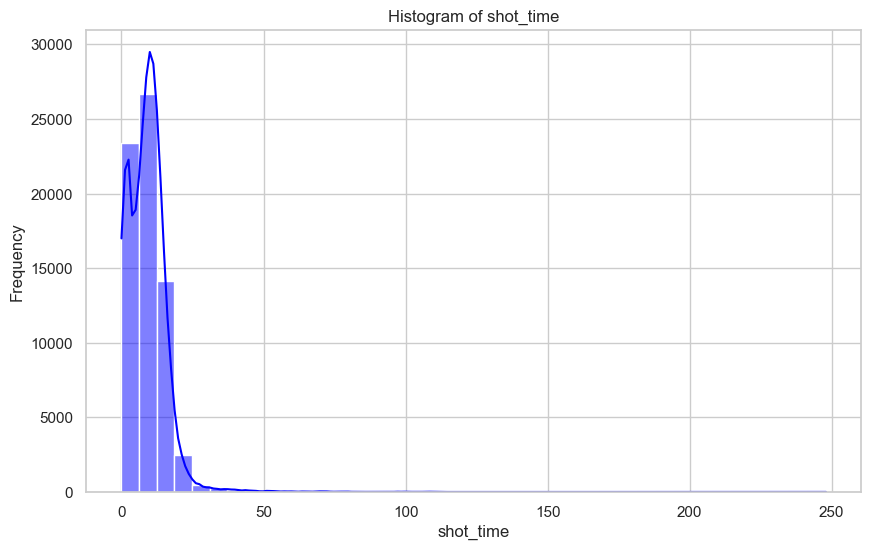

In [42]:
columns= ["shot_distance" , "shot_time" ]
for c in columns:  
    # Set the style of seaborn
    sns.set(style="whitegrid")

    # Create a histogram for shot distance
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=c, bins=40, kde=True, color="blue")
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {c}')
    plt.show()

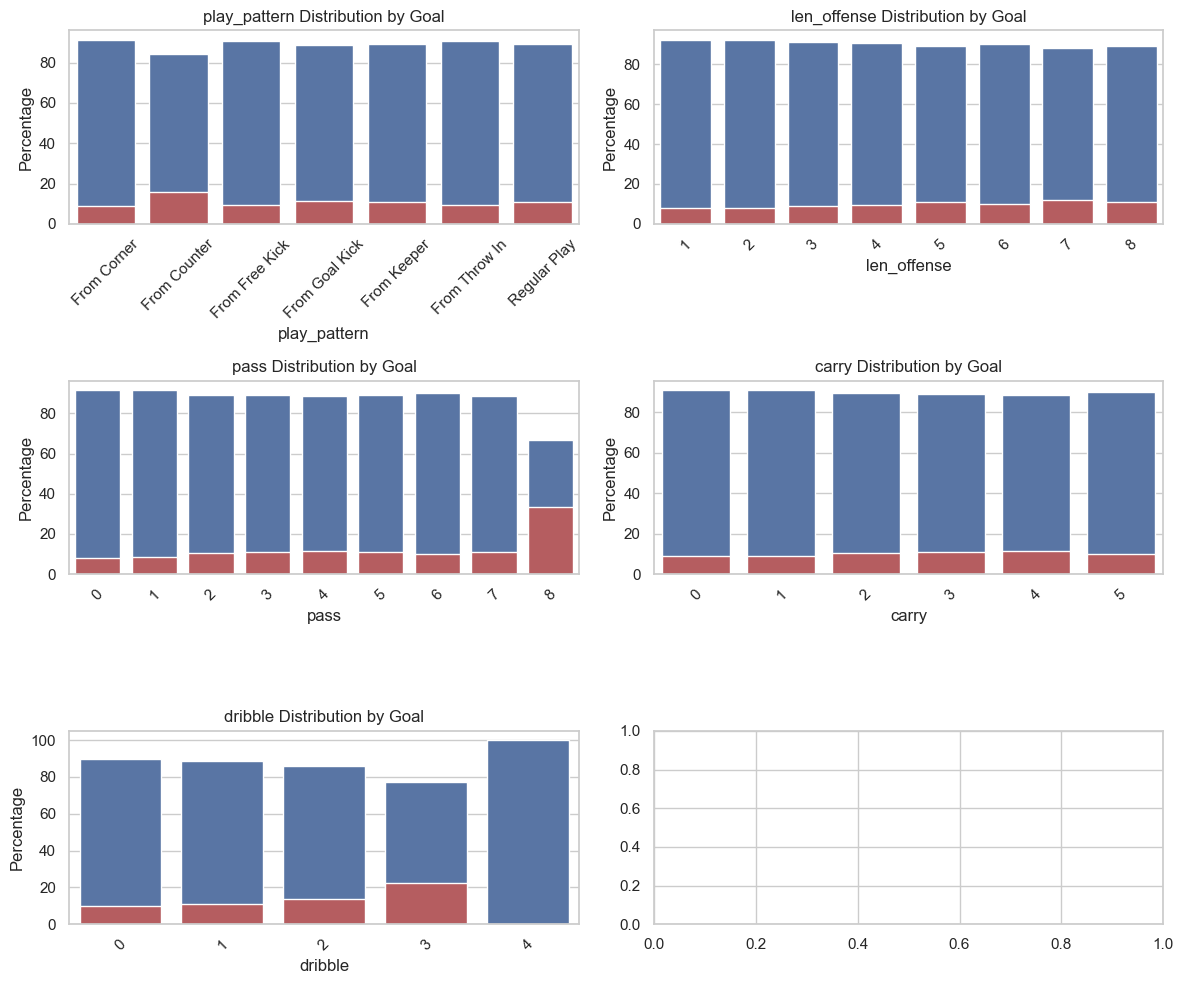

In [57]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
columns = ["play_pattern", "len_offense", "pass", "carry", "dribble"]
spots = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]
for c, s in zip(columns, spots):
    # Calculate percentage values for each option within 'is_goal' groups
    percentages = df.groupby([c, 'is_goal']).size().unstack('is_goal').reset_index()
    percentages.fillna(0, inplace=True)
    total_per_option = percentages[0] + percentages[1]
    percentages[0] = (percentages[0] / total_per_option) * 100
    percentages[1] = (percentages[1] / total_per_option) * 100

    sns.barplot(x=c, y=0, data=percentages, ax=axes[s[0], s[1]], color='b', label='Goal')
    sns.barplot(x=c, y=1, data=percentages, ax=axes[s[0], s[1]], color='r', label='Not Goal')

    axes[s[0], s[1]].set_title(f'{c} Distribution by Goal')
    axes[s[0], s[1]].set_ylabel('Percentage')
    axes[s[0], s[1]].set_xlabel(c, ha='center')
        # Reformat x-axis labels to be horizontal
    for tick in axes[s[0], s[1]].get_xticklabels():
        tick.set_rotation(45)

# Adjust layout
plt.tight_layout()
plt.show()







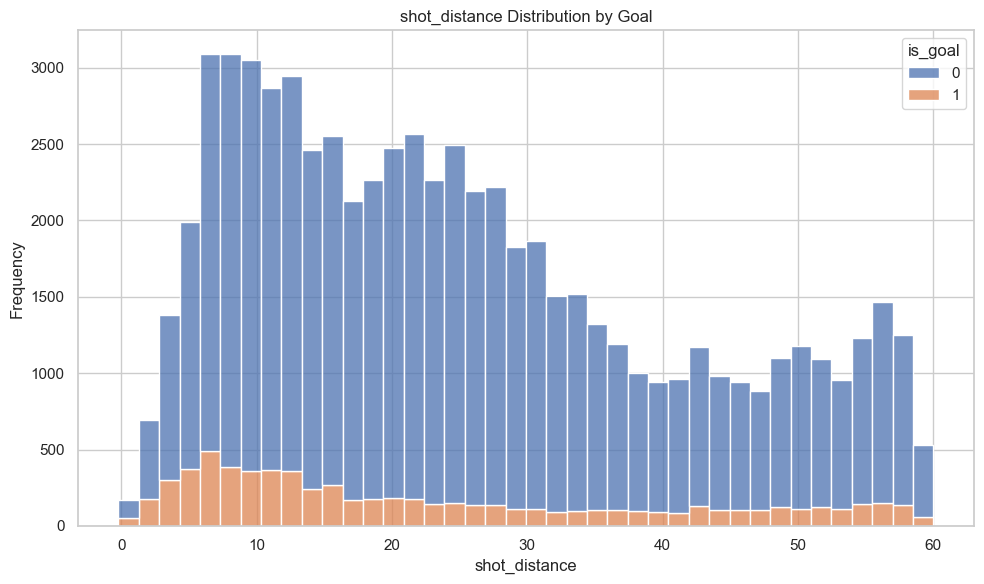

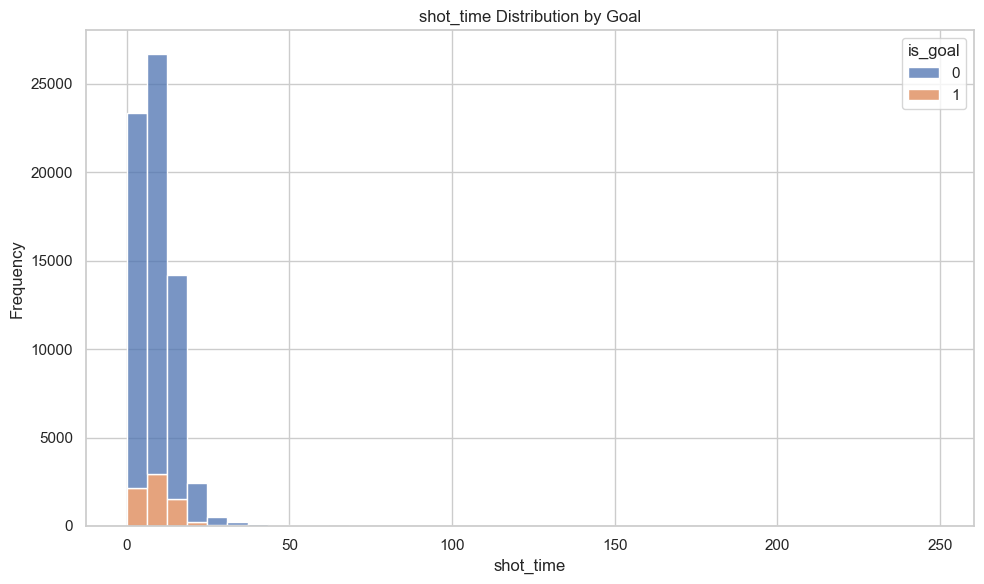

In [64]:
# Set the style of seaborn
sns.set(style="whitegrid")
columns = ["shot_distance" , "shot_time"]
for c in columns:
    # Plot histogram for "shot_distance"
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=c, hue='is_goal', multiple='stack', bins=40)

    plt.title(f'{c} Distribution by Goal')
    plt.ylabel('Frequency')
    plt.xlabel(c)
    plt.tick_params(axis='x', rotation=0)

    # Show the first histogram
    plt.tight_layout()
    plt.show()









# cluster


In [2]:
#start from here
with open('data/data_with_cluster.pkl', 'rb') as file:
        list_offense = pickle.load(file)

# create distance metric - DTW

In [31]:
num_offenses = 6000

score_dict_dtw = {}
for i in tqdm(range(num_offenses), desc="Processing", ncols=100):
    score_dict_dtw[str(i)] = {}
    score_dict_dtw[str(i)][str(i)] = 0
    for j in range(i + 1, num_offenses):
        cost = DTW(list_offense[i], list_offense[j])
        score_dict_dtw[str(i)][str(j)] = cost
        
       

with open('data/Score_dtw_update(6000).json', 'w') as file:
    json.dump(score_dict_dtw, file, indent = 4)


Processing: 100%|█████████████████████████████████████████████| 6000/6000 [2:19:33<00:00,  1.40s/it]


In [24]:
'''with open('data/Score_dtw_update(6000).json', 'w') as file:
    json.dump(score_dict_dtw, file, indent = 4)'''

In [4]:
with open('data/Score_dtw_update_6000.json') as json_file:
    score_dict_dtw = json.load(json_file)

In [ ]:
score_dict_dtw.keys()

In [5]:
def DTW_for_model(index1, index2):
    try:
        i1 = str(int(index1[0]))
        i2 = str(int(index2[0]))
    except:
        i1 = str(int(index1))
        i2 = str(int(index2))
    try:
        return score_dict_dtw[i1][i2]
    except:
        return score_dict_dtw[i2][i1]

In [27]:
#all_index = [i for i in range(len(list_offense))]
all_index = [i for i in range(6000)]

global_centroid_dtw  = calculate_centroid(all_index , DTW_for_model)
global_centroid_dtw

380

In [6]:
global_centroid_dtw = 380

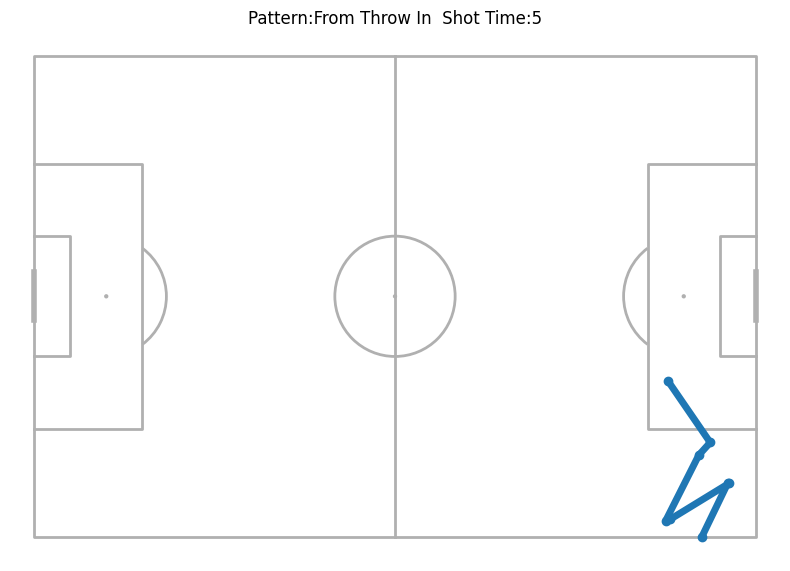

0.04024939202859623


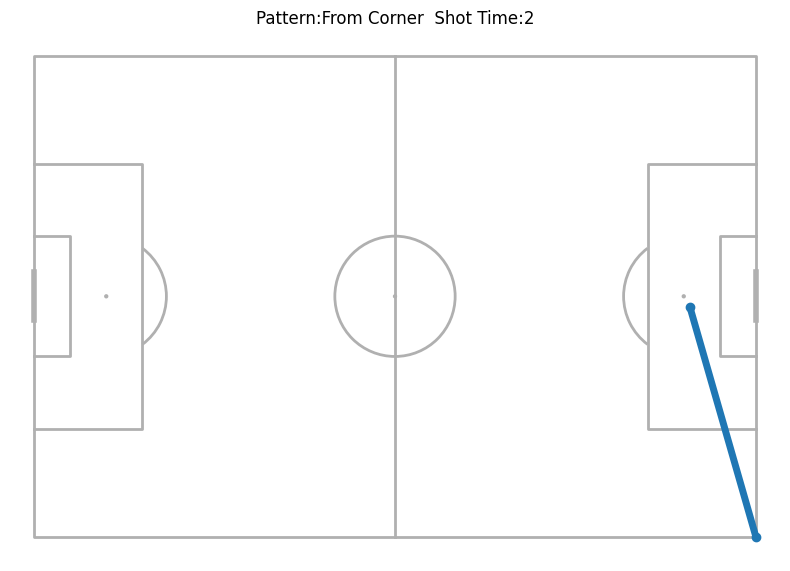

0.13284665092026604


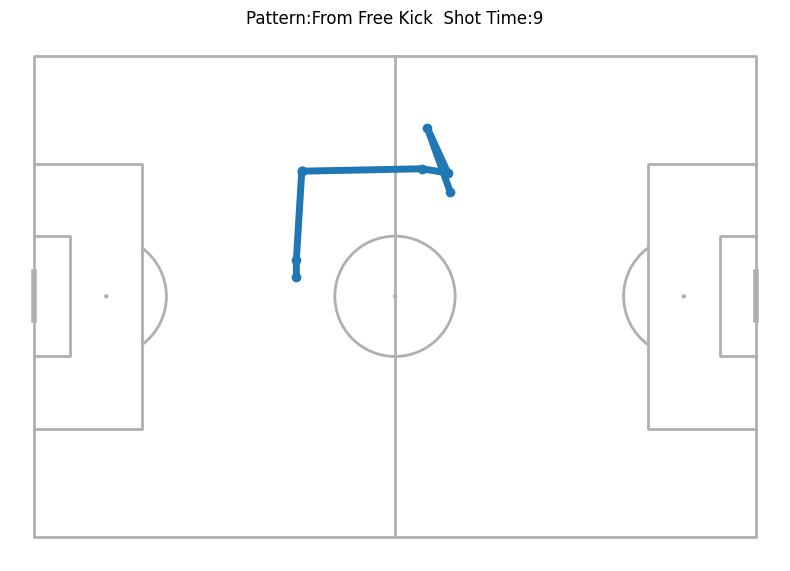

In [10]:
list_offense[2].plot_offense()
print(score_dict_dtw["2"]["6"])
list_offense[6].plot_offense()
print(score_dict_dtw["2"]["5"])
list_offense[5].plot_offense()



In [11]:
list_score = []
for i in score_dict_dtw.keys():
    for j in score_dict_dtw[i].keys():
        if score_dict_dtw[i][j] != 0:
            list_score.append(score_dict_dtw[i][j])



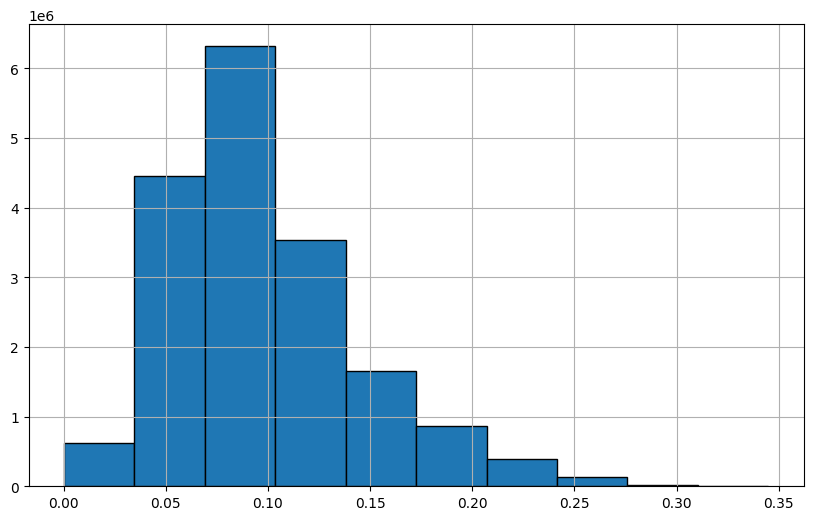

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(list_score, bins=10, edgecolor='black')
plt.grid(True)
plt.show()

# Clustering

## DBSCAN

In [7]:
from sklearn.cluster import DBSCAN


In [ ]:
data = np.array([offense.index_in_current_list for offense in list_offense])
data_reshaped = data.reshape(-1, 1)
data_reshaped = data_reshaped[:6000]

eps_list = [0.01, 0.02 ,0.03 , 0.04 , 0.05 , 0.06 , 0.07]
min_samples_list = [3,4,5,6,7,8]
results = []



for e in eps_list:
    for s in min_samples_list:
        dbscan = DBSCAN(metric= DTW_for_model, eps=e, min_samples=s)
        labels_per_index = dbscan.fit_predict(data_reshaped)
        labels_per_cluster = convert_to_clusters(labels_per_index)
        print(labels_per_cluster)
        if len(labels_per_cluster) - 1 <= 1:
            print(len(labels_per_cluster[-1]))
            continue
        score = calculate_bcss_wcss_ratio(labels_per_cluster[:-1], DTW_for_model, global_centroid_dtw)
        silhouette_score = calculate_silhouette_score(labels_per_cluster[:-1], DTW_for_model)
        outliers = len(labels_per_cluster[-1])
        num_clusters = len(labels_per_cluster) - 1
        # Append results to the list
        results.append({
            "Epsilon": e,
            "Min Samples": s,
            "Score": score,
            "silhouette score" :silhouette_score,
            "Outliers": outliers,
            "Num Clusters": num_clusters
        })
        print(results[-1])       
        

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)


In [12]:
#x.append(results)
results_df = pd.DataFrame(x)


In [13]:
results_df.head()

,Epsilon,Min Samples,Score,silhouette score,Outliers,Num Clusters
0,0.01,3,1.855236,-0.372973,4560,49
1,0.01,4,1.762795,-0.443401,4697,14
2,0.01,5,3.613145,0.269182,4753,8
3,0.01,6,3.760591,0.303136,4795,5
4,0.01,7,3.872752,0.282397,4829,6


In [14]:
results_df.to_csv('data/results_dbscan.csv', index=False)


In [19]:
results_df = results_df[results_df['Outliers'] < 1000]
results_df = results_df[results_df['Num Clusters'] < 50]
results_df = results_df[results_df['Num Clusters'] >2]
results_df = results_df.sort_values(by='silhouette score', ascending=False)

results_df

,Epsilon,Min Samples,Score,silhouette score,Outliers,Num Clusters
47,0.0250,9,1.004824,-0.161144,983,3
15,0.0400,2,1.002597,-0.170349,49,6
40,0.0250,7,1.005107,-0.193177,907,3
46,0.0275,7,1.006751,-0.207247,600,4
45,0.0275,6,1.004758,-0.210996,569,3
44,0.0275,5,1.006403,-0.211264,533,4
43,0.0275,4,1.006551,-0.217203,511,4
38,0.0250,5,1.008367,-0.222282,817,5
39,0.0250,6,1.007322,-0.278201,863,5
37,0.0250,4,1.008340,-0.281563,759,7


In [35]:
e = 0.025
s = 9

In [36]:
dbscan = DBSCAN(metric= DTW_for_model, eps=e, min_samples=s)
labels_per_index = dbscan.fit_predict(data_reshaped)
labels_per_cluster = convert_to_clusters(labels_per_index)
score = calculate_bcss_wcss_ratio(labels_per_cluster[:-1], DTW_for_model, global_centroid_dtw)
silhouette_score = calculate_silhouette_score(labels_per_cluster[:-1], DTW_for_model)
outliers = len(labels_per_cluster[-1])
num_clusters = len(labels_per_cluster) - 1

In [38]:
print("silhouette score" , silhouette_score)
print("score" , score)
print("number of clusters" , num_clusters)
print("number of outliers" , outliers)

silhouette score -0.16114418374913436
score 1.004823835743701
number of clusters 3
number of outliers 983


In [39]:
len(labels_per_cluster[0])

4993

In [54]:
cluster_centroid =  calculate_centroid(labels_per_cluster[0] , DTW_for_model)

min_dist = 0
for l in labels_per_cluster[0]:
    d = DTW_for_model(cluster_centroid , l)
    min_dist += d

min_dist /= len(labels_per_cluster[0])

print(cluster_centroid)
print(min_dist)


380
0.06212004997928601


In [55]:
counter_outliers = 0
counter_not_outliers = 0
for i , offense in enumerate(list_offense):
    d_temp = DTW(list_offense[i],list_offense[cluster_centroid])
    if d_temp < min_dist:
        offense.dbscan_is_outlier = cluster_centroid
        counter_not_outliers += 1
    else:
        offense.dbscan_is_outlier = -1
        counter_outliers +=1


print("counter_outliers" , counter_outliers)
print("counter_not_outliers" , counter_not_outliers)

counter_outliers 33494
counter_not_outliers 30378


In [56]:
with open('data/data_with_cluster.pkl', 'wb') as file:
    pickle.dump(list_offense, file)

## K-means

In [31]:
data = np.array([offense.index_in_current_list for offense in list_offense])
data = data[:6000]

max_iterations = 300
results = []
for n in range(4,15):
    n_clusters = n
    labels, centroids = custom_kmeans(data, n_clusters, max_iterations, DTW_for_model)
    label_mapping = {label: i for i, label in enumerate(centroids)}
    labels_per_index = [label_mapping[l] for l in labels]
    labels_per_cluster = convert_to_clusters(labels_per_index)
    score = calculate_bcss_wcss_ratio(labels_per_cluster, DTW_for_model, global_centroid_dtw)
    silhouette_score = calculate_silhouette_score(labels_per_cluster, DTW_for_model)
    num_clusters = len(centroids) 
        
    # Append results to the list
    results.append({
        "Score": score,
        "silhouette score" :silhouette_score,
        "Num Clusters": num_clusters
    })
    print(results[-1])

results_df = pd.DataFrame(results)




{'Score': 1.4392266531780455, 'silhouette score': 0.17637671771458227, 'Num Clusters': 4}
{'Score': 1.507571137951932, 'silhouette score': 0.129088183309824, 'Num Clusters': 5}
{'Score': 1.543543601547853, 'silhouette score': 0.10772932388358364, 'Num Clusters': 6}
{'Score': 1.7384855500060374, 'silhouette score': 0.16287941953499682, 'Num Clusters': 7}
{'Score': 1.7329085338318622, 'silhouette score': 0.11391689327393577, 'Num Clusters': 8}
{'Score': 1.8058439401617876, 'silhouette score': 0.12735502735772633, 'Num Clusters': 9}
{'Score': 1.8627908790843235, 'silhouette score': 0.12064955829379005, 'Num Clusters': 10}
{'Score': 1.8960257308188009, 'silhouette score': 0.11577873910616641, 'Num Clusters': 11}
{'Score': 1.9164962105389083, 'silhouette score': 0.12134529748040765, 'Num Clusters': 12}
{'Score': 1.9102794286287992, 'silhouette score': 0.1016470149151129, 'Num Clusters': 13}
{'Score': 2.011930711499111, 'silhouette score': 0.10830940043442006, 'Num Clusters': 14}


In [32]:
results_df

,Score,silhouette score,Num Clusters
0,1.439227,0.176377,4
1,1.507571,0.129088,5
2,1.543544,0.107729,6
3,1.738486,0.162879,7
4,1.732909,0.113917,8
5,1.805844,0.127355,9
6,1.862791,0.120650,10
7,1.896026,0.115779,11
8,1.916496,0.121345,12
9,1.910279,0.101647,13


In [33]:
results_df.to_csv('data/results_kmeans.csv', index=False)


In [34]:
results_df = pd.read_csv('data/results_kmeans.csv')

In [35]:
results_df.head(15)

,Score,silhouette score,Num Clusters
0,1.439227,0.176377,4
1,1.507571,0.129088,5
2,1.543544,0.107729,6
3,1.738486,0.162879,7
4,1.732909,0.113917,8
5,1.805844,0.127355,9
6,1.862791,0.120650,10
7,1.896026,0.115779,11
8,1.916496,0.121345,12
9,1.910279,0.101647,13


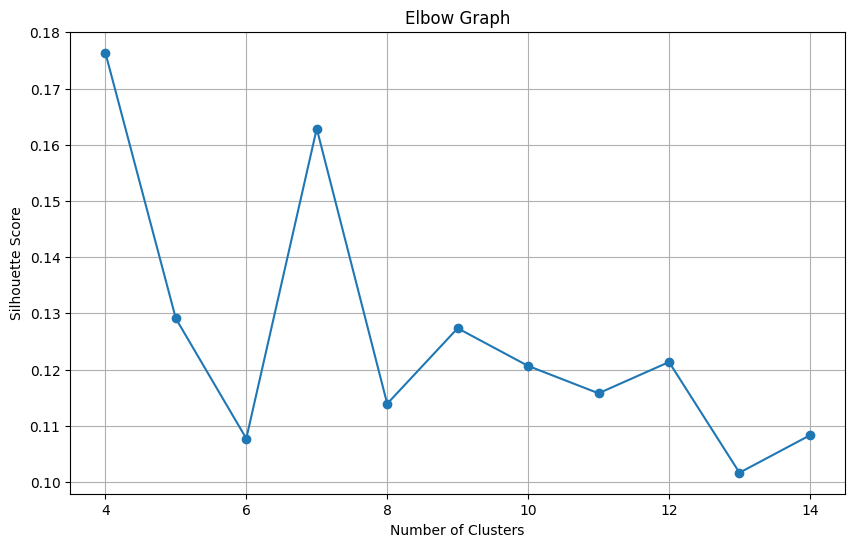

In [36]:
# Plotting the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(results_df["Num Clusters"], results_df["silhouette score"], marker='o')
plt.title("Elbow Graph")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [48]:
data = np.array([offense.index_in_current_list for offense in list_offense])
data = data[:6000]

max_iterations = 300
n_clusters = 4
labels, centroids = custom_kmeans(data, n_clusters, max_iterations, DTW_for_model)
label_mapping = {label: i for i, label in enumerate(centroids)}
labels_per_index = [label_mapping[l] for l in labels]
labels_per_cluster = convert_to_clusters(labels_per_index)
score = calculate_bcss_wcss_ratio(labels_per_cluster, DTW_for_model, global_centroid_dtw)
silhouette_score = calculate_silhouette_score(labels_per_cluster, DTW_for_model)
num_clusters = len(centroids) 
    
print("Score  ", score)
print("silhouette score  " ,silhouette_score)
print("Num Clusters  ", num_clusters)
 



stop_before_max_iteration
Score   1.4392266531780455
silhouette score   0.17637671771458227
Num Clusters   4


In [49]:
for l in labels_per_cluster[-1]:
    print("cluster: ", len(l))

In [50]:
centroids

[5575, 200, 1761, 4061]

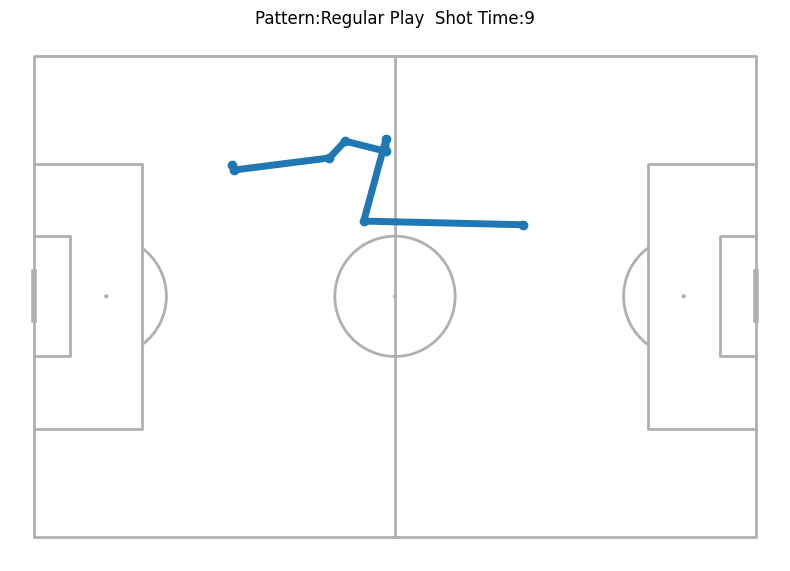

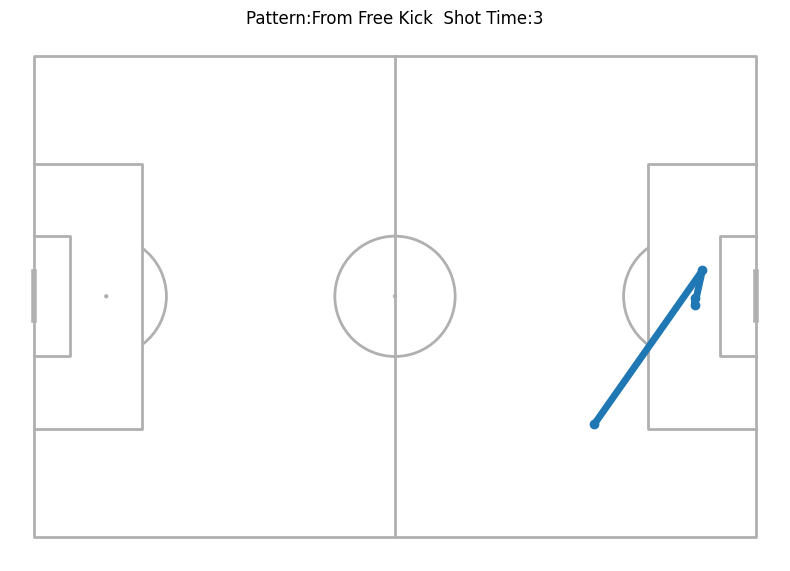

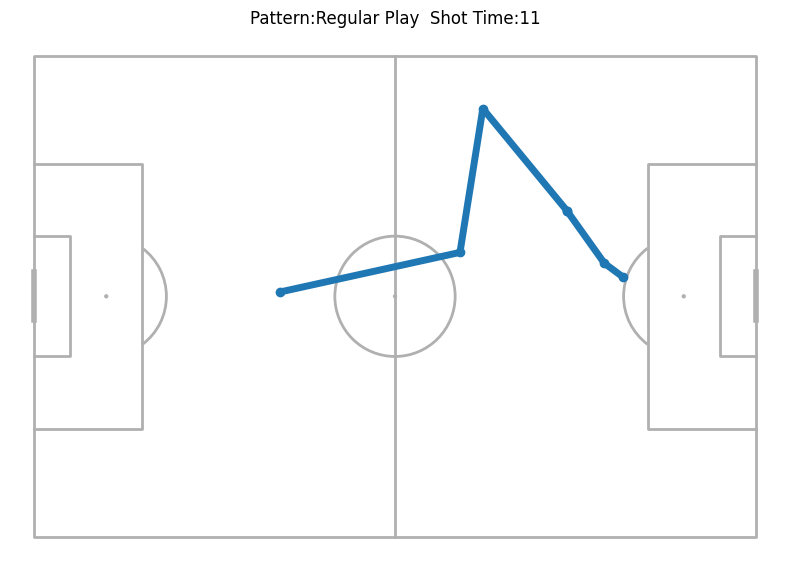

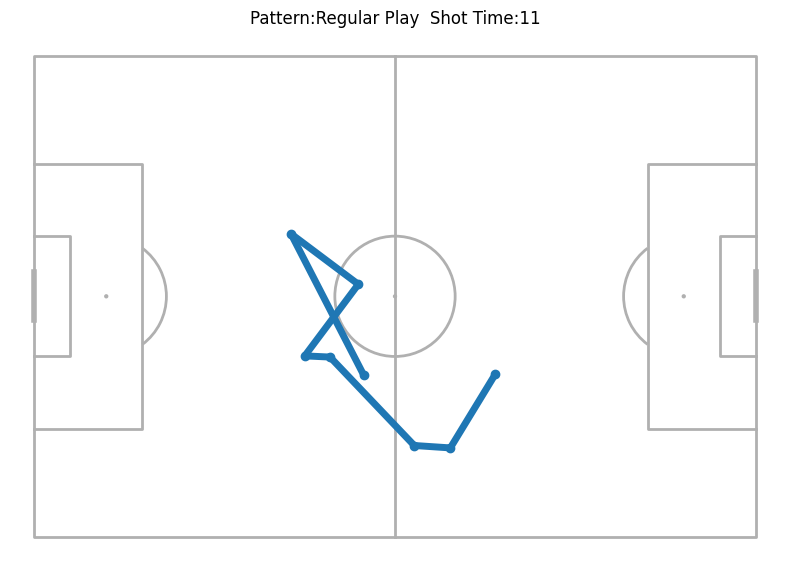

In [51]:
for c in centroids:
    list_offense[c].plot_offense()

In [54]:
for i , offense in enumerate(list_offense):
    min_index = -1
    min_value = 1000
    for c in centroids:
        min_temp = DTW(list_offense[i], list_offense[c])
        if min_temp < min_value:
            min_index = c
            min_value = min_temp

    offense.clusters_centroid_kmeans = min_index

    

In [ ]:
for i , offense in enumerate(list_offense):
    print(offense.clusters_centroid_kmeans)

In [56]:
with open('data/data_with_cluster.pkl', 'wb') as file:
    pickle.dump(list_offense, file)

## Hierarchical Clustering

In [92]:
with open('data/data_with_cluster.pkl', 'rb') as file:
    list_offense = pickle.load(file)

In [60]:
data = np.array([offense.index_in_current_list for offense in list_offense])
data_reshaped = data.reshape(-1, 1)
data_reshaped = data_reshaped[:6000]

In [61]:
# Make a distance matrix from the DTW dictionary
dist_matrix = np.zeros((len(data_reshaped), len(data_reshaped)))
for i in range(len(data_reshaped)):
    for j in range(len(data_reshaped)):
        dist_matrix[i, j] = DTW_for_model(i,j)

In [62]:
from scipy.spatial.distance import squareform
# The hierarchical clustering linkage gets condensed list and not distance matrix
condensed_dist = squareform(dist_matrix)


In [63]:
def hierarchical_evaluate(linkage_matrix, n_clusters):
    cluster_assignments = choose_nclusters(linkage_matrix, n_clusters)
    labels_per_cluster = convert_to_clusters(cluster_assignments)
    score = calculate_bcss_wcss_ratio(labels_per_cluster, DTW_for_model, global_centroid_dtw)
    silhouette_score = calculate_silhouette_score(labels_per_cluster, DTW_for_model)
    
    print(f"score : {score}")
    print(f"silhouette_score : {silhouette_score}")

### Average linkage


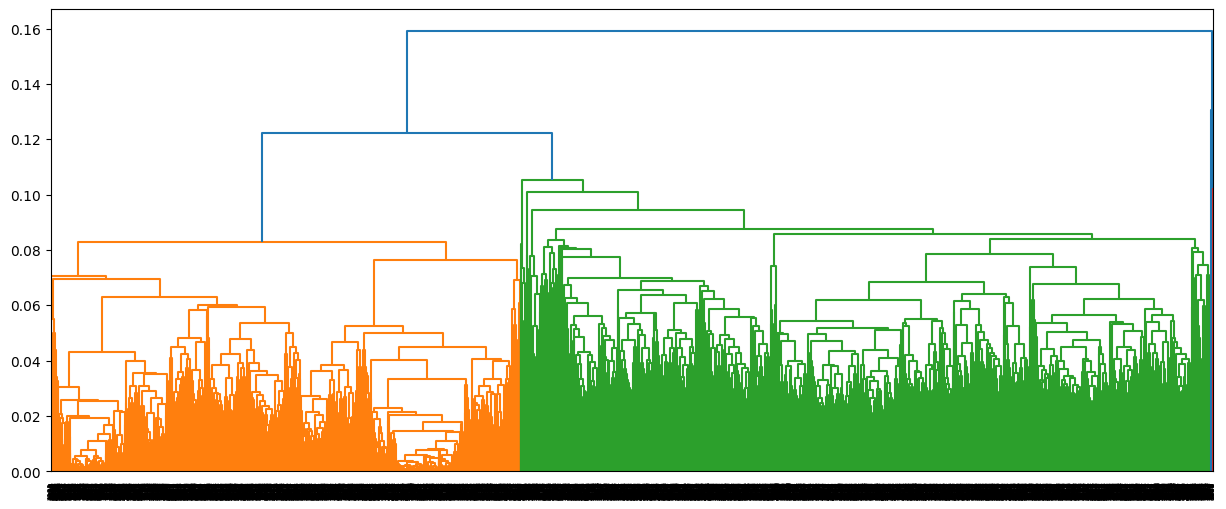

In [68]:
linkage_matrix_average = hierarchical_clustering(condensed_dist, 'average')


In [69]:
print("4 Clusters:")
hierarchical_evaluate(linkage_matrix_average, 4)
print("5 Clusters:")
hierarchical_evaluate(linkage_matrix_average, 5)

4 Clusters:
score : 1.2296357303193586
silhouette_score : 0.301895265853036
5 Clusters:
score : 1.235080809771877
silhouette_score : 0.18121059145127041


### Complete linkage


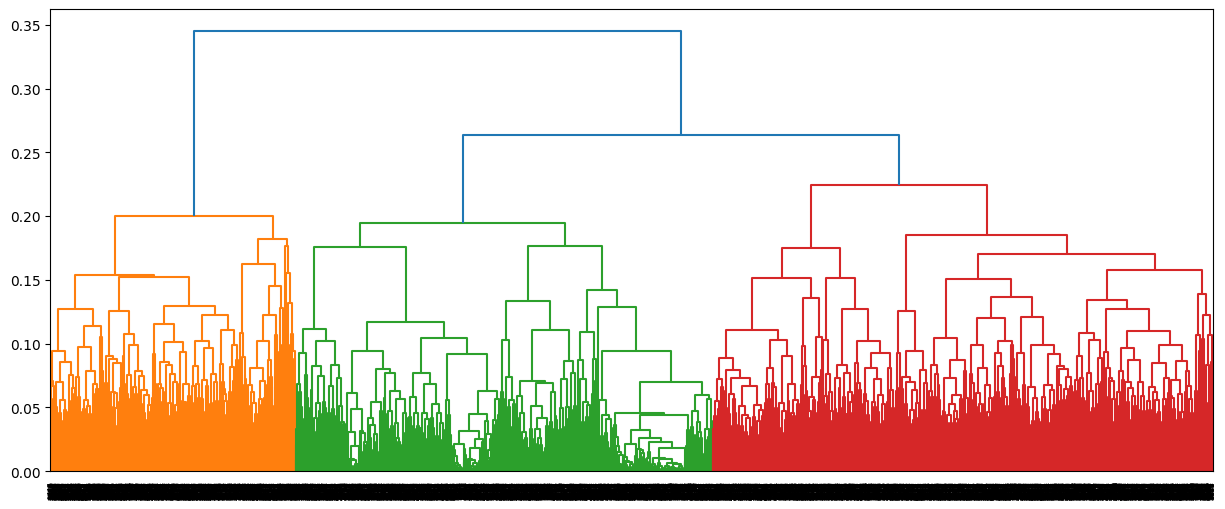

In [70]:
linkage_matrix_complete = hierarchical_clustering(condensed_dist, 'complete')


In [71]:
print("2 Clusters")
hierarchical_evaluate(linkage_matrix_complete, 2)
print("3 Clusters")
hierarchical_evaluate(linkage_matrix_complete, 3)
print("5 Clusters")
hierarchical_evaluate(linkage_matrix_complete, 5)


2 Clusters
score : 1.1633840794023527
silhouette_score : 0.28628654170774737
3 Clusters
score : 1.3102593517026755
silhouette_score : 0.2578154121663353
5 Clusters
score : 1.3917281235091865
silhouette_score : 0.14459394022418054


### Ward linkage

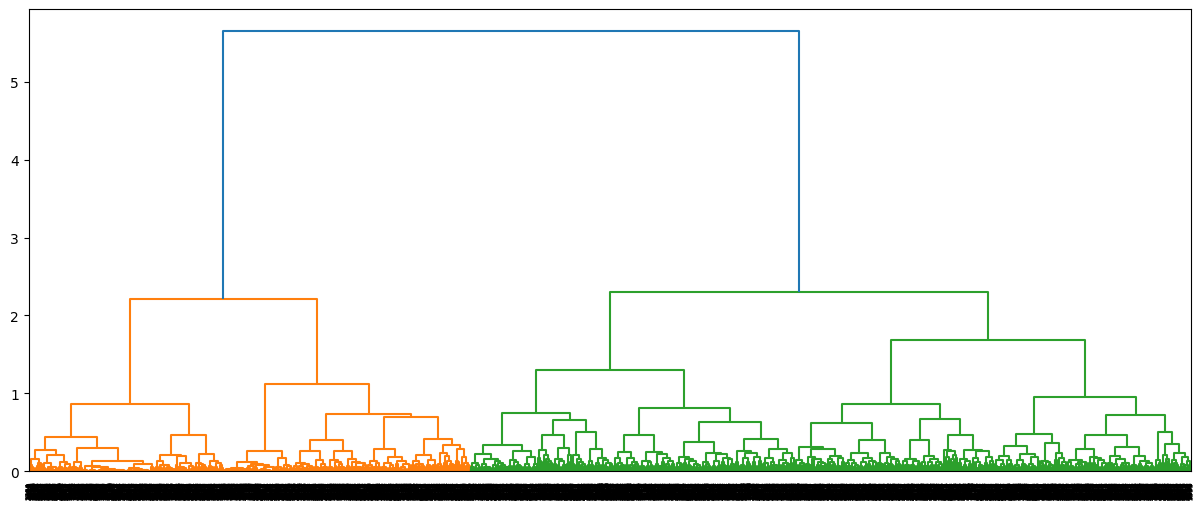

In [72]:
linkage_matrix_ward = hierarchical_clustering(condensed_dist, 'ward')

In [73]:
print("2 Clusters")
hierarchical_evaluate(linkage_matrix_ward, 2)
print("4 Clusters")
hierarchical_evaluate(linkage_matrix_ward, 4)
print("6 Clusters")
hierarchical_evaluate(linkage_matrix_ward, 6)

2 Clusters
score : 1.218561327873985
silhouette_score : 0.3756948548007071
4 Clusters
score : 1.4287626903981652
silhouette_score : 0.1710054081343898
6 Clusters
score : 1.542743253817278
silhouette_score : 0.13262865007509692


### Check for outliers

In [9]:
shots_from_left_half = []
for offense in list_offense:
    shot_coords = offense.list_coords[-1]
    if shot_coords[0] <= 60:
        shots_from_left_half.append(offense.index_in_current_list)
print(f"Number of shots from left half of the pitch : {len(shots_from_left_half)}")

Number of shots from left half of the pitch : 9740


#### Plot sample of shots from left half

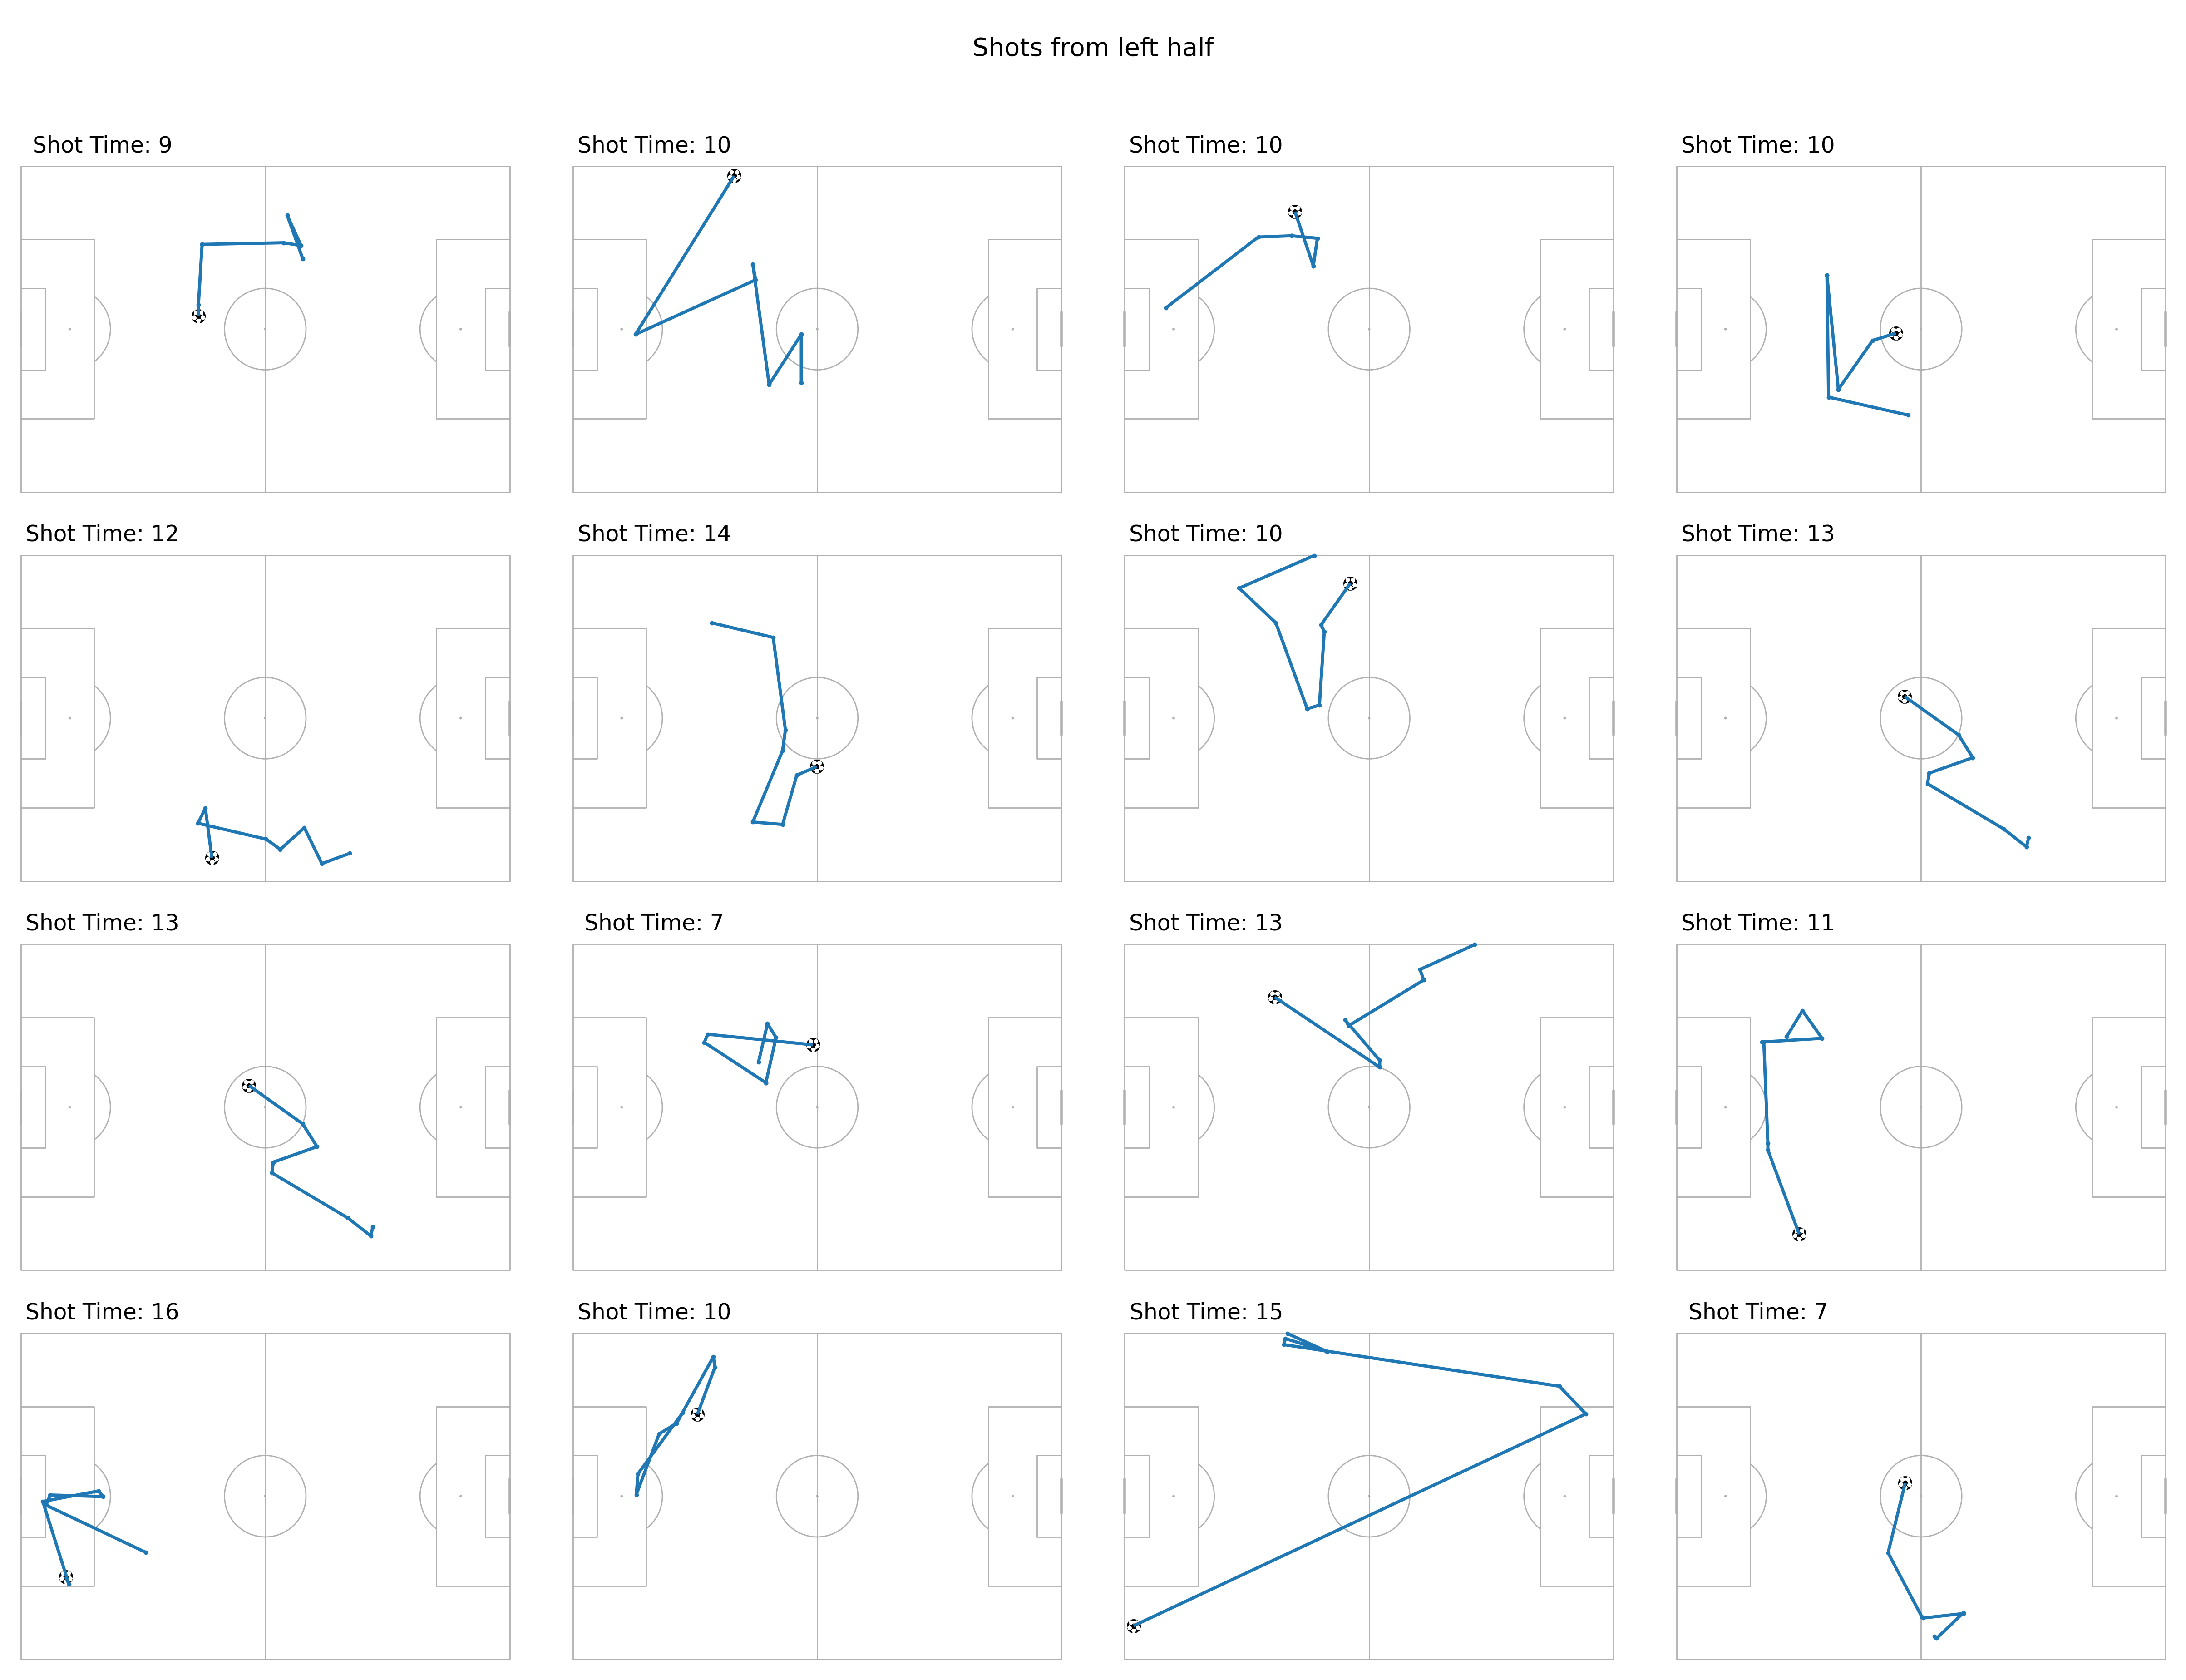

In [212]:
offense_grid(list_offense=[list_offense[i] for i in shots_from_left_half[:16]], title_text='Shots from left half')

#### Ward linkage - without outliers

In [ ]:
filtered_data = np.array([offense.index_in_current_list for offense in list_offense[:6000] if offense.index_in_current_list not in shots_from_left_half])

filtered_dist_matrix = np.zeros((len(filtered_data), len(filtered_data)))
for i, row_index in enumerate(filtered_data):
    for j, col_index in enumerate(filtered_data):
        filtered_dist_matrix[i, j] = DTW_for_model(row_index,col_index)
        
condensed_dist_filtered = squareform(filtered_dist_matrix)

global_centroid_dtw_filtered = calculate_centroid(filtered_data , DTW_for_model)

In [ ]:
def hierarchical_evaluate_filtered(linkage_matrix, n_clusters, filtered_data):
    cluster_assignments = choose_nclusters(linkage_matrix, n_clusters)
    labels_per_cluster = convert_to_clusters(cluster_assignments)
    
    for i, cluster in enumerate(labels_per_cluster):
        if len(cluster) != 0 :
            labels_per_cluster[i] = [filtered_data[j] for j in cluster]
    score = calculate_bcss_wcss_ratio(labels_per_cluster, DTW_for_model, global_centroid_dtw_filtered)
    silhouette_score = calculate_silhouette_score(labels_per_cluster, DTW_for_model)
    
    print(f"score : {score}")
    print(f"silhouette_score : {silhouette_score}")

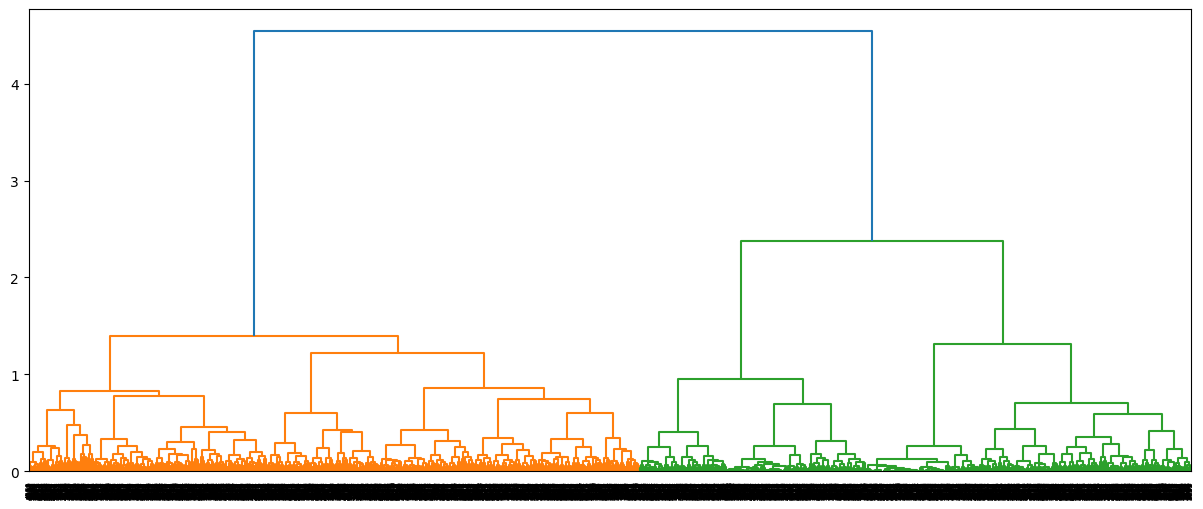

In [185]:
linkage_matrix_ward_filtered = hierarchical_clustering(condensed_dist_filtered, 'ward')

In [186]:
print("3 Clusters")
hierarchical_evaluate_filtered(linkage_matrix_ward_filtered, 3, filtered_data)
print("4 Clusters")
hierarchical_evaluate_filtered(linkage_matrix_ward_filtered, 4, filtered_data)
print("6 Clusters")
hierarchical_evaluate_filtered(linkage_matrix_ward_filtered, 6, filtered_data)
print("8 Clusters")
hierarchical_evaluate_filtered(linkage_matrix_ward_filtered, 7, filtered_data)

3 Clusters
score : 1.3254592351994807
silhouette_score : 0.2978409742299807
4 Clusters
score : 1.393491341886202
silhouette_score : 0.1575175162021359
6 Clusters
score : 1.5257091204119044
silhouette_score : 0.12097219715062411
8 Clusters
score : 1.5762219273150613
silhouette_score : 0.1182289629925459


##### Centroids

In [294]:
chosen_linkage = linkage_matrix_ward_filtered
chosen_n_clusters = 3

cluster_assignments_chosen = choose_nclusters(linkage_matrix_ward_filtered, chosen_n_clusters)
labels_per_cluster_chosen = convert_to_clusters(cluster_assignments_chosen)

centroids = []
for cluster in labels_per_cluster_chosen:
    if len(cluster) != 0:
        centroid = calculate_centroid(cluster, DTW_for_model)
        centroids.append(centroid)

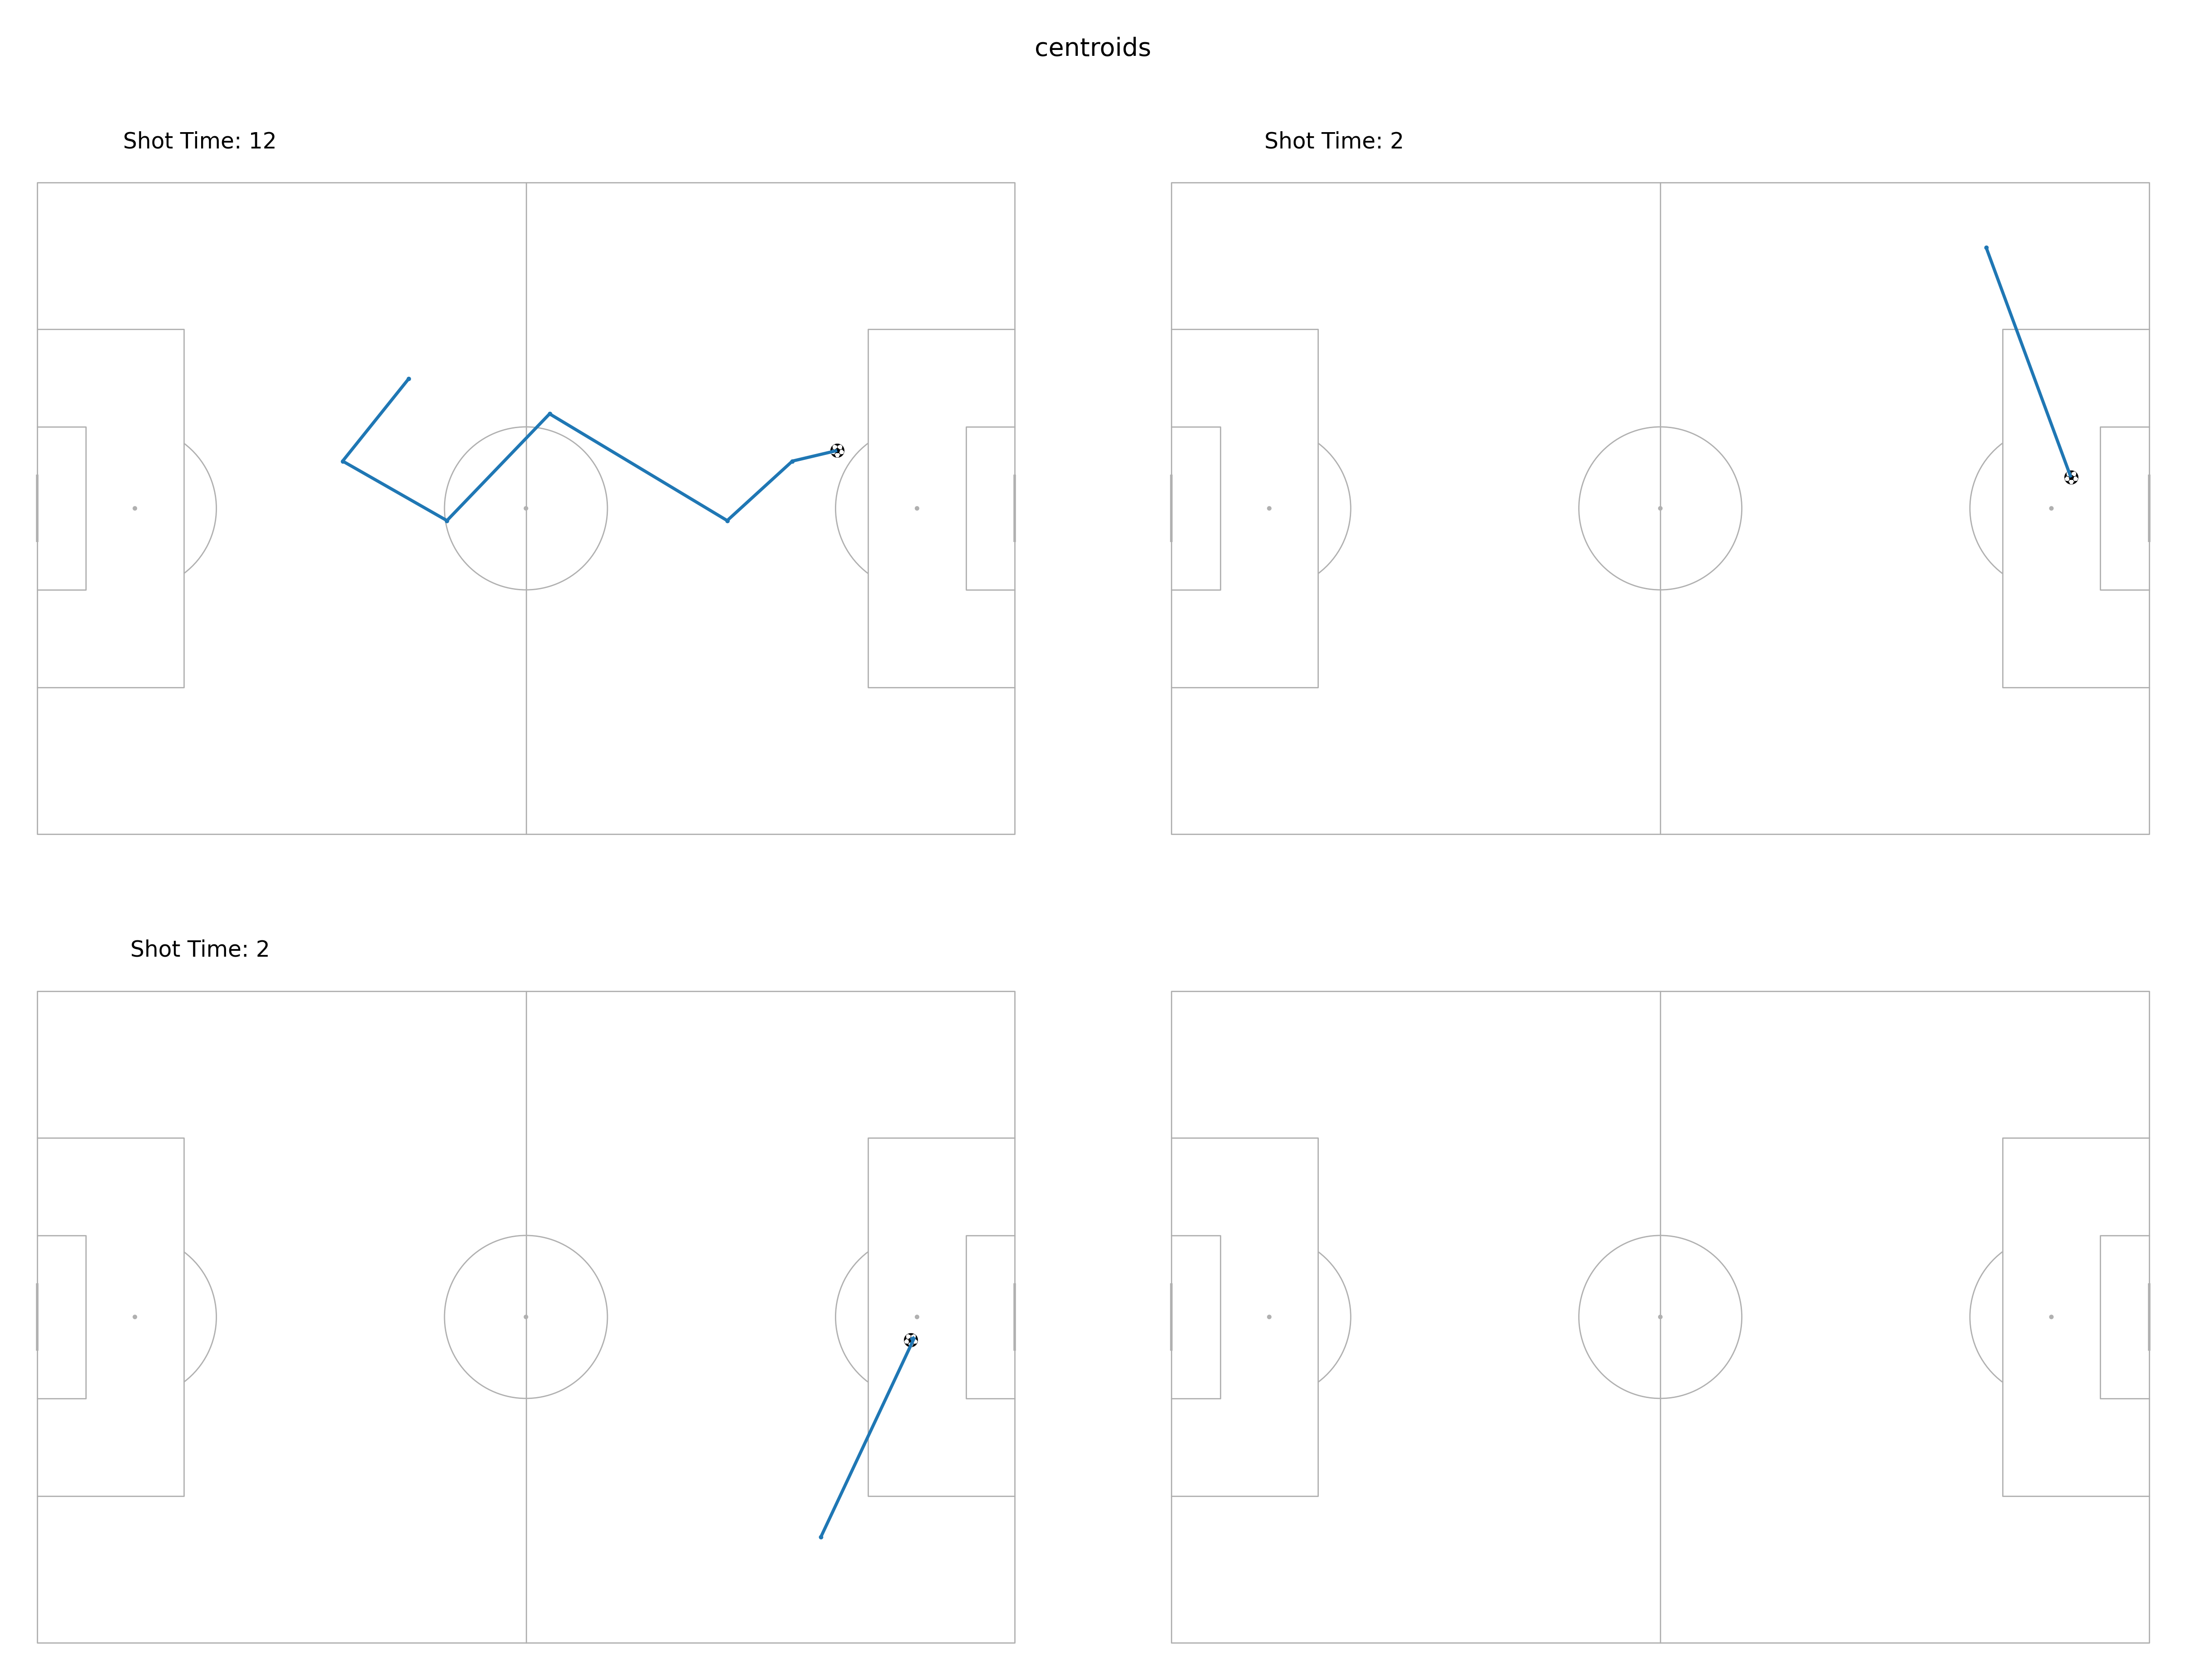

In [295]:
offense_grid([list_offense[i] for i in centroids], 2,2, 'centroids')

##### Clusters

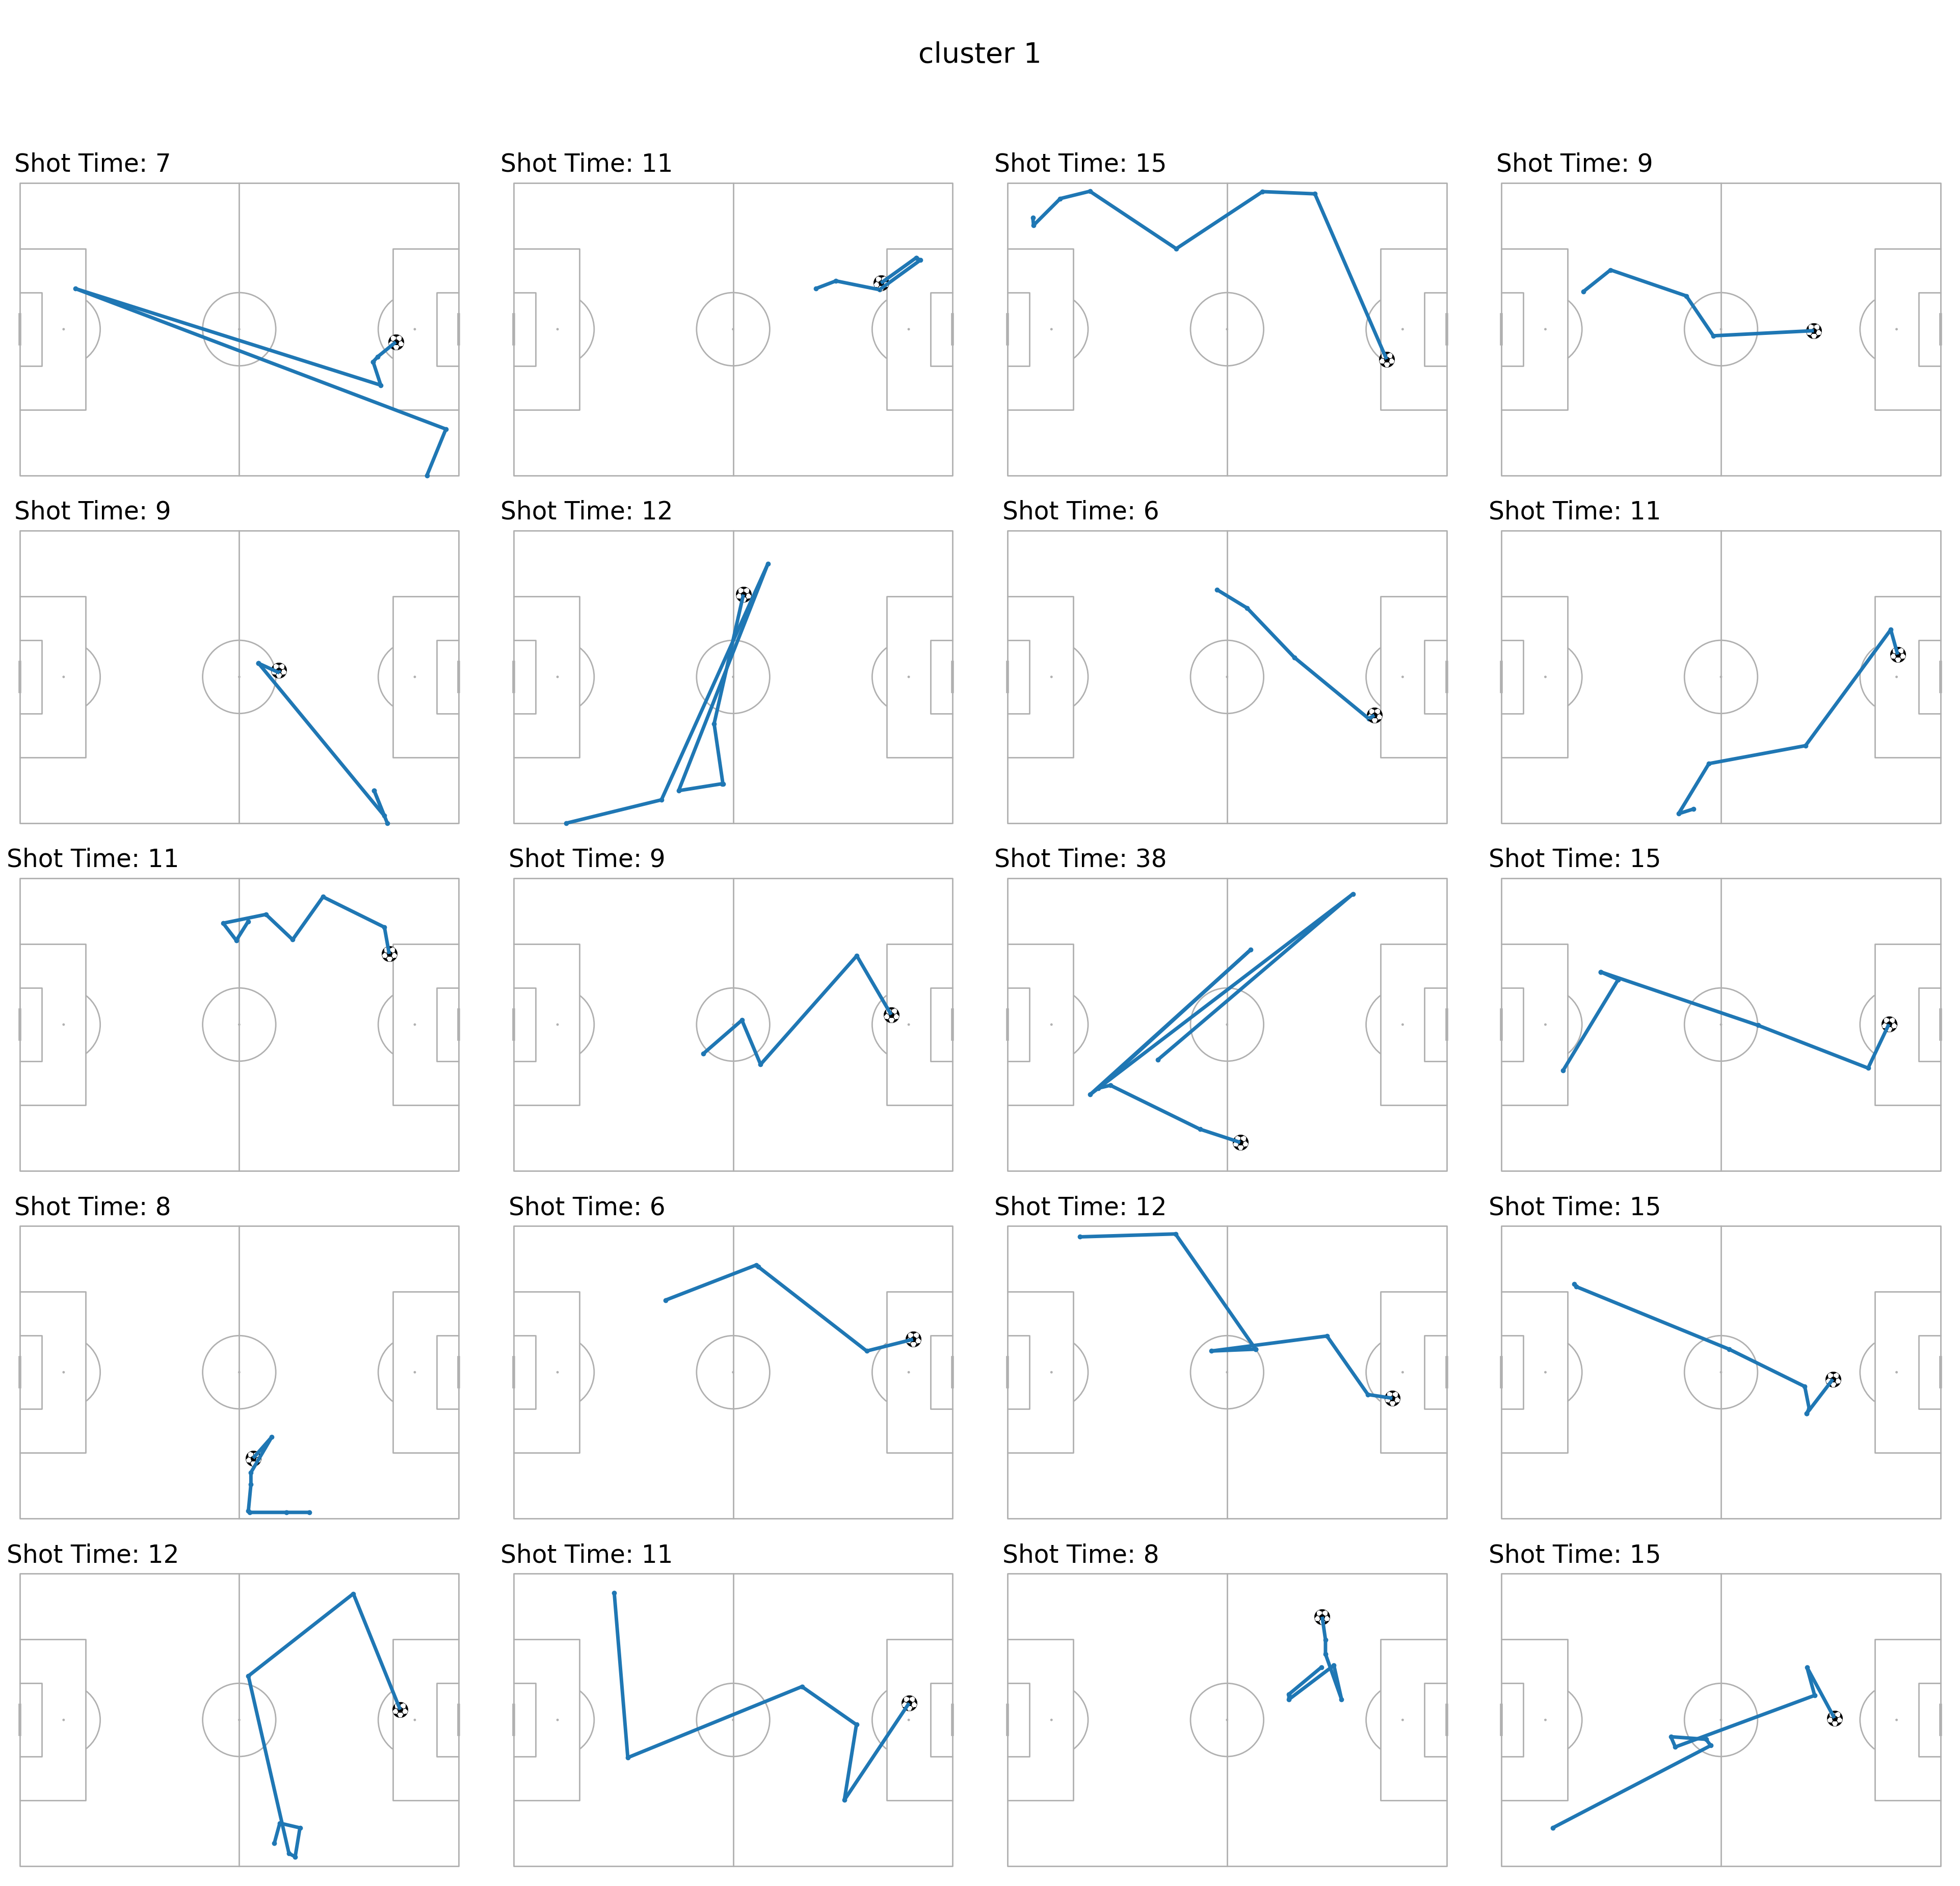

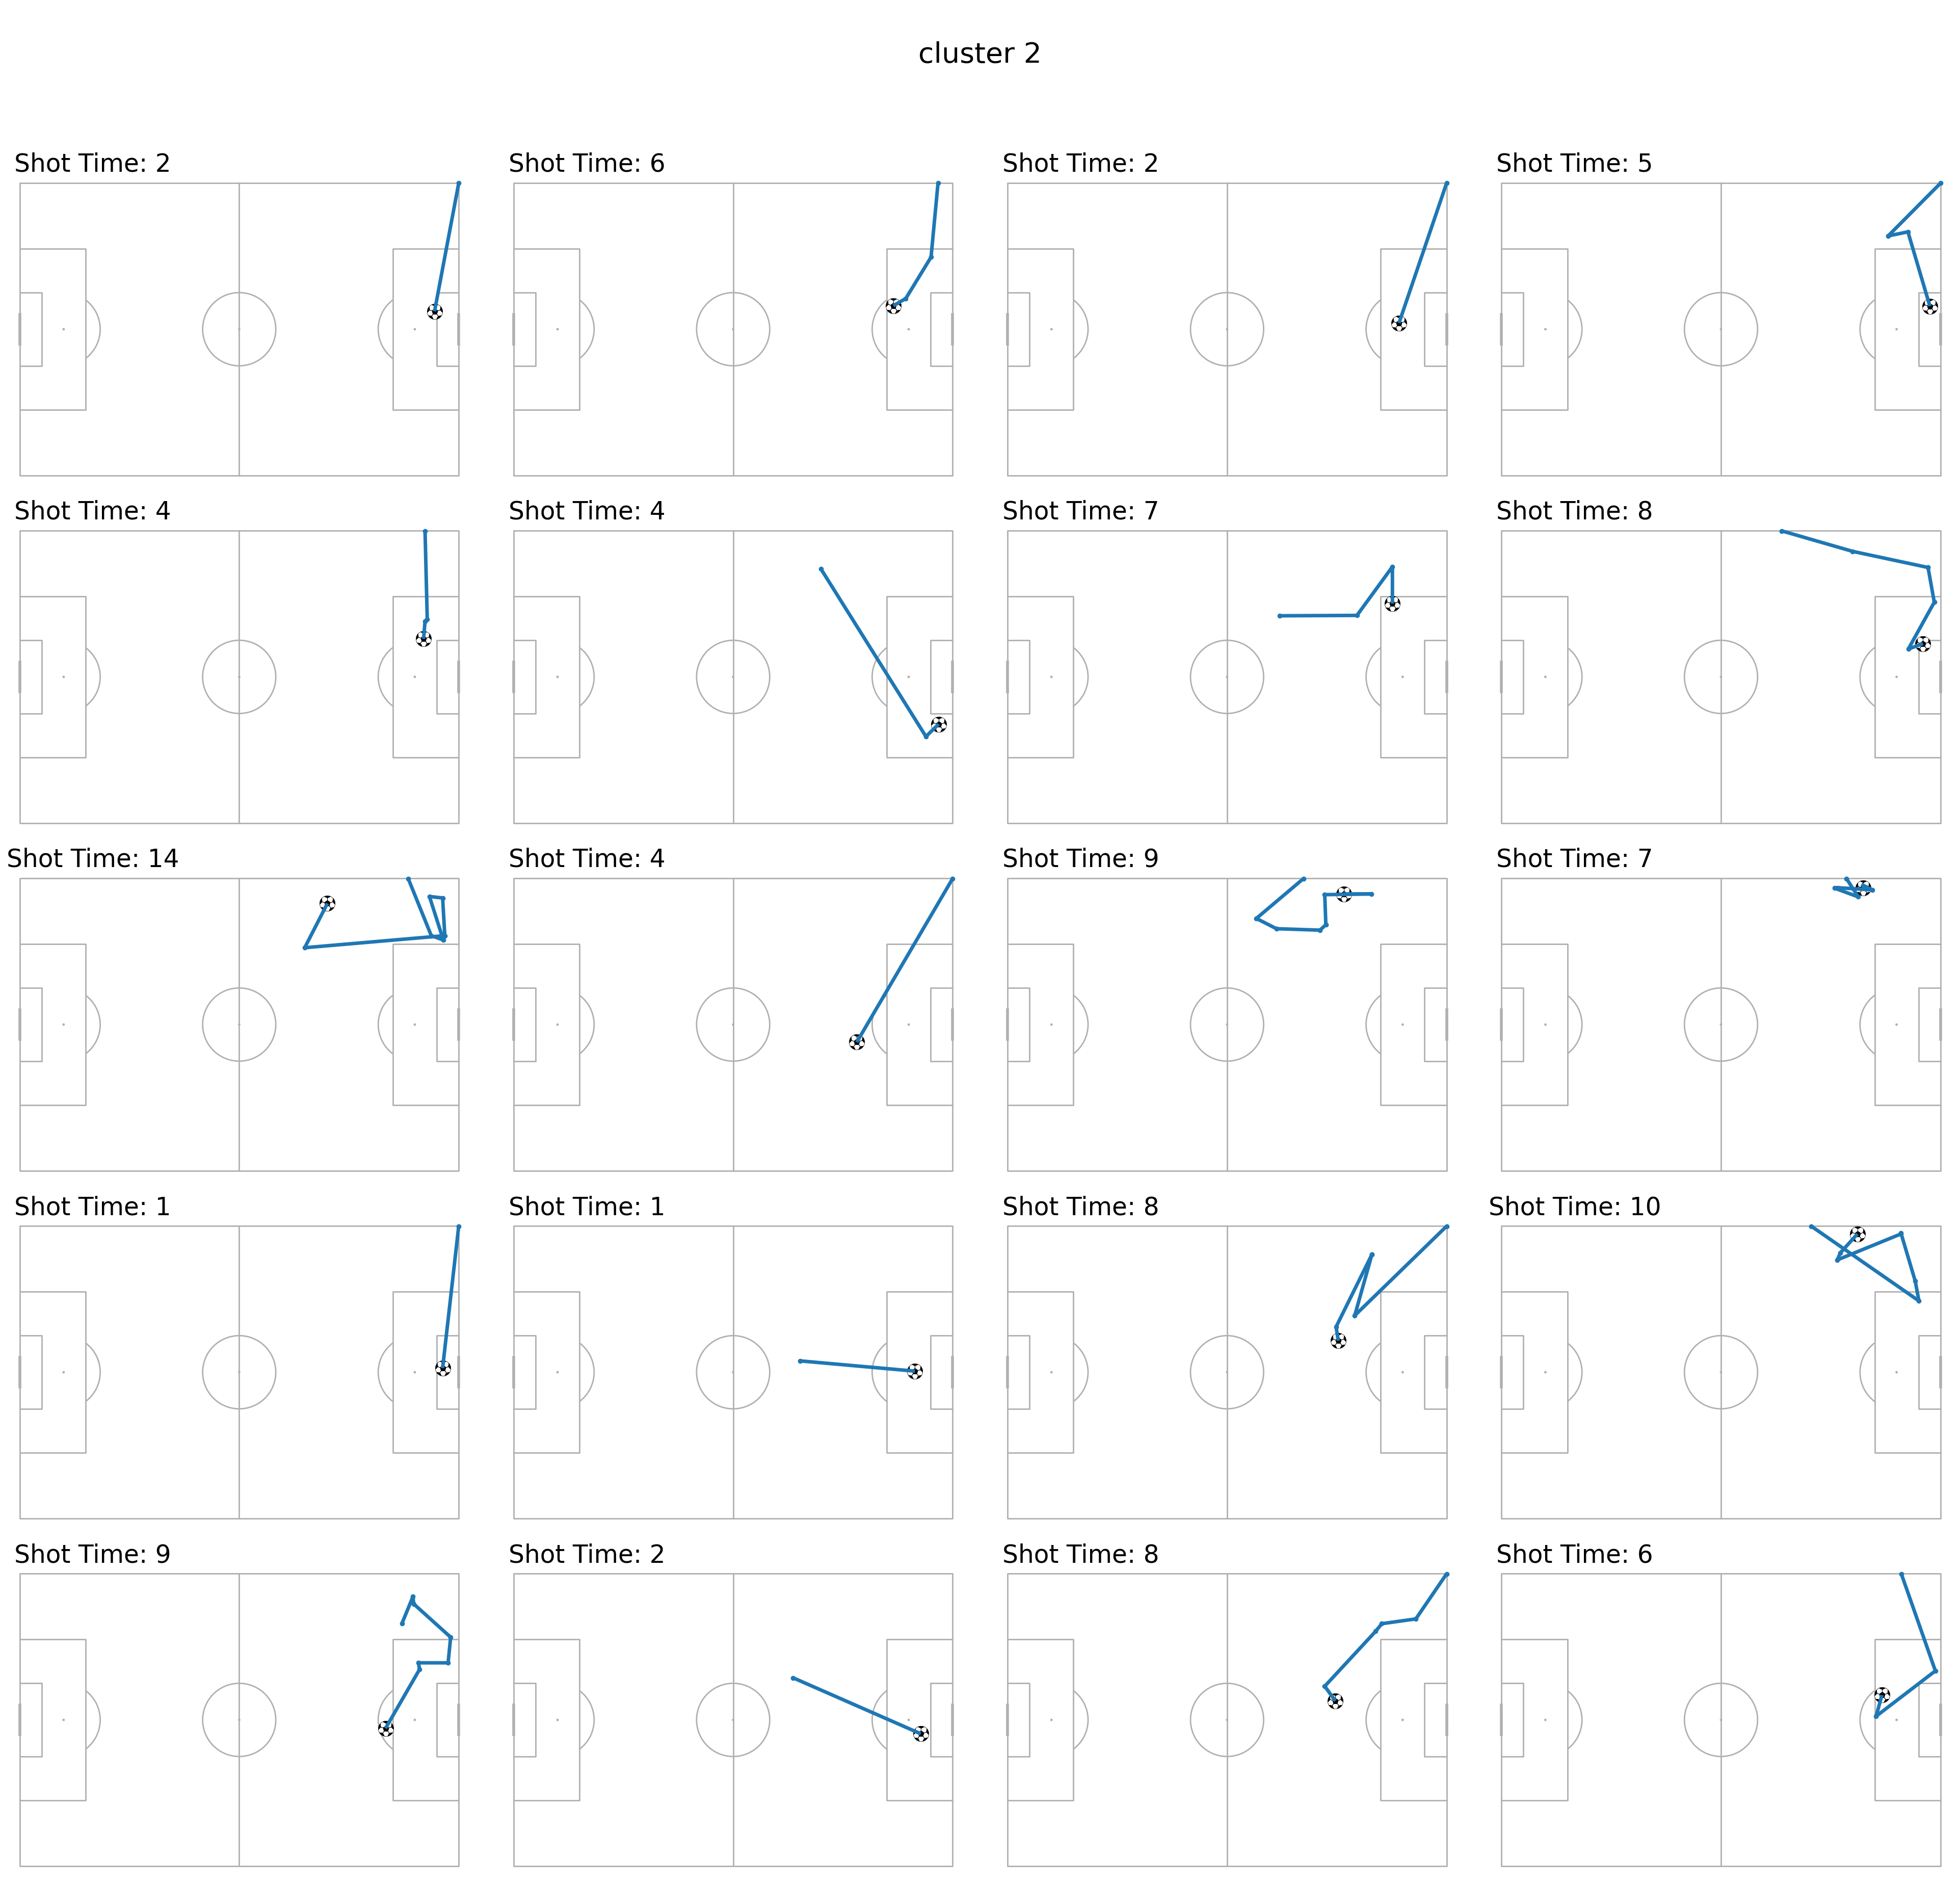

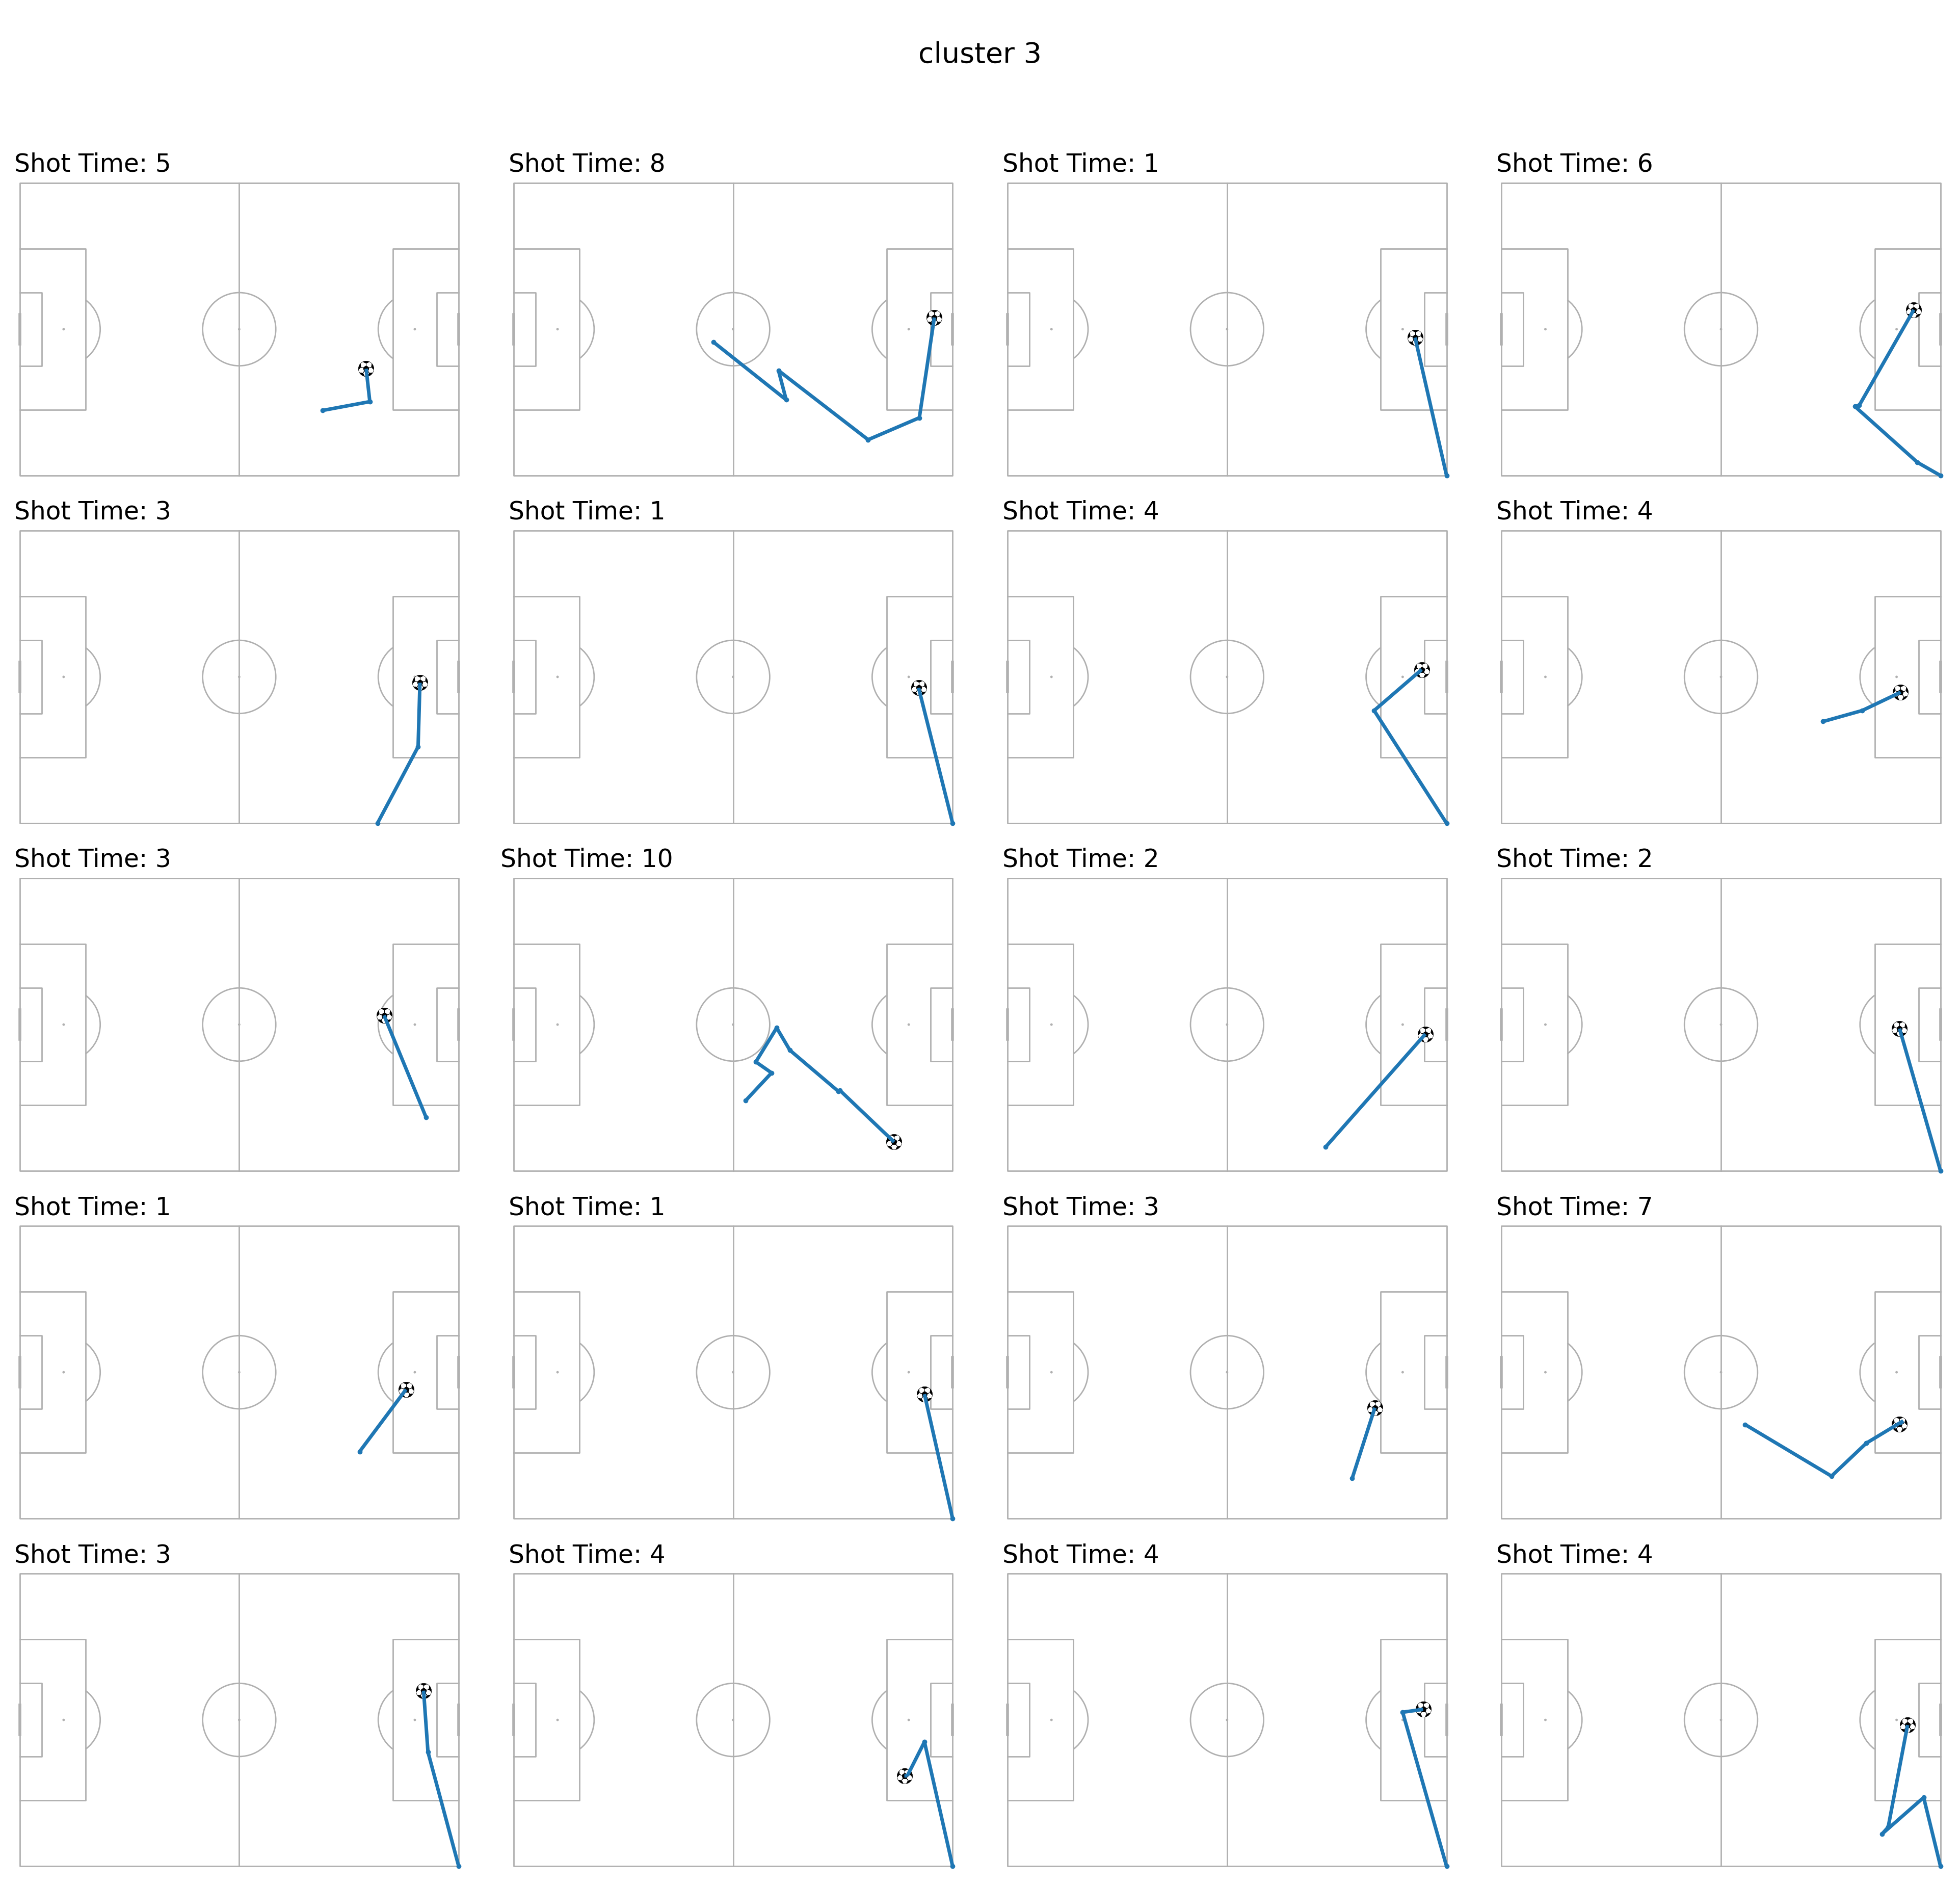

In [293]:
for i, cluster in enumerate(labels_per_cluster_chosen):
    if len(cluster) != 0 :
        labels_per_cluster_chosen[i] = [filtered_data[j] for j in cluster]

for i, cluster in enumerate(labels_per_cluster_chosen):
    if (i != 0) and (i != len(labels_per_cluster_chosen)-1):
        sample = np.random.choice(cluster, size=min(20, len(cluster)), replace=False)
        offense_grid([list_offense[i] for i in sample], nrows=5 , ncols=4, title_text=f"cluster {i}")


### choose the best model

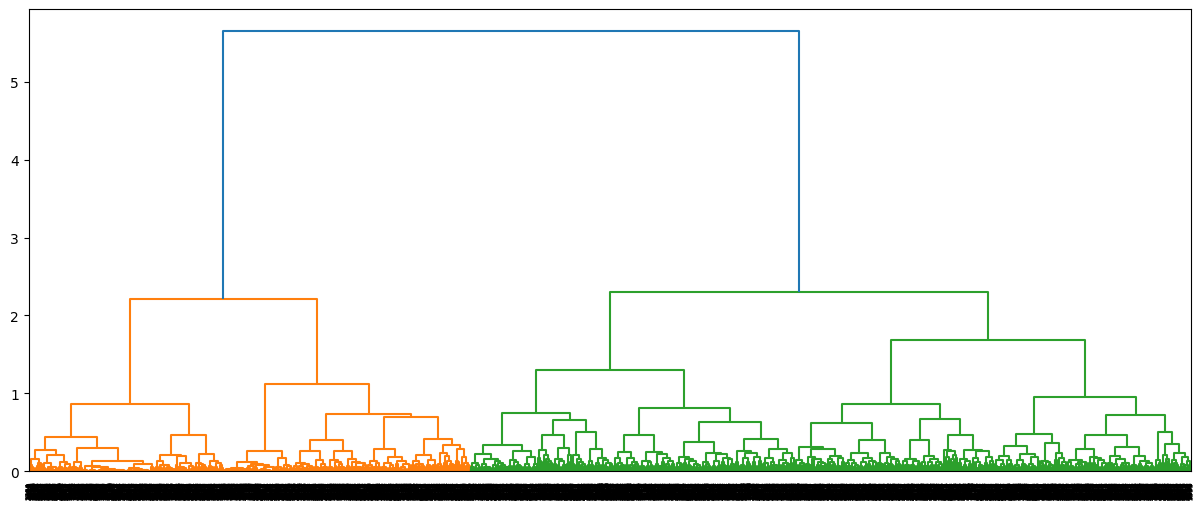

In [74]:
linkage_matrix = hierarchical_clustering(condensed_dist, 'ward')
cluster_assignments = choose_nclusters(linkage_matrix, 2)


In [76]:
labels_per_cluster = convert_to_clusters(cluster_assignments)


In [82]:
c1 = labels_per_cluster[1]
c2 = labels_per_cluster[2]

In [83]:
centroid_1 = calculate_centroid(c1 , DTW_for_model)
centroid_2 = calculate_centroid(c2 , DTW_for_model)
print(centroid_1 , "|" , centroid_2)

2467 | 1720


In [84]:
centroids = [centroid_1 , centroid_2]

In [89]:
for i , offense in enumerate(list_offense):
    min_index = -1
    min_value = 1000
    for c in centroids:
        min_temp = DTW(list_offense[i], list_offense[c])
        if min_temp < min_value:
            min_index = c
            min_value = min_temp

    offense.clusters_centroid_hierarchical = min_index

In [ ]:
for i , offense in enumerate(list_offense):
    print(offense.clusters_centroid_hierarchical)

In [91]:
with open('data/data_with_cluster.pkl', 'wb') as file:
    pickle.dump(list_offense, file)